In [1]:
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras as keras
from tensorflow.keras import layers, models, optimizers, metrics
tf.config.optimizer.set_jit(True)
import warnings
warnings.filterwarnings('ignore')
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
from scipy.ndimage import convolve

class Connect4Game(object):
  def __init__(self):
    self.board = np.zeros((6, 7)).astype(np.int8)
    self.tops = np.zeros(7).astype(np.int8)
    self.moves_played = 0
    self.pieces = {1: "|0|",
                   0: "|·|",
                   -1:"|O|"}
  def render(self):
    for row in reversed(range(6)):
      print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))
  def reset(self):
    self.board *= 0
    self.tops *= 0
    self.moves_played = 0
  def play(self, col, color):
    self.board[int(self.tops[col])][col] = color
    self.tops[col] += 1
    self.moves_played += 1
  def result(self):
    """ Returns 0 if it's a tie; returns None if the game is not over; returns -1 if player -1 wins, and 1 if player 1 wins."""
    if self.moves_played == 42: return 0
    kernel_row = [[1, 1, 1, 1]]
    kernel_col = [[1],
                  [1],
                  [1],
                  [1]]
    kernel_dia = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
    kernel_dia2 = [[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0],
                  [1, 0, 0, 0]]
    for kernel in [np.array(kernel_row).astype(np.int8), np.array(kernel_col).astype(np.int8), np.array(kernel_dia).astype(np.int8), np.array(kernel_dia2).astype(np.int8)]:
      check = convolve(self.board, kernel, mode='constant')
      #print(check)
      if (check == 4).any(): return 1
      if (check == -4).any(): return -1
    return None 

In [4]:
def human_play():
  game = Connect4Game()
  turn = 1
  while game.result() == None:
    game.render()
    game.play(int(input()), turn); turn *= -1
  print("Result: ", game.result())

In [5]:
from PIL import Image
from collections import defaultdict
import random
import time, tqdm
import ray

ray.init(ignore_reinit_error=True, num_cpus = os.cpu_count(), log_to_driver=False)

class A0(object):
    def __init__(self, name, model_complexity = 2, n_simulations = 64, model = None):
        # Hyperparameters
        self.n_simulations = n_simulations # Keep it simple
        self.c = 1 # weight for exploration
        self.n_parallel = os.cpu_count()
        
        # Basic
        self.name = name
        self.simulator = Connect4Game() # Would be different if this were muzero
        self.model_complexity = model_complexity # 1+
        if model == None:
            self.model = self.create_model(conv_layers = self.model_complexity, describe = True)
        else:
            print("Loading model from memory.")
            self.model = model
        
        # Monte Carlo Tree Search stuff
        self.visited = set()
        self.Q, self.P, self.N = defaultdict(lambda: np.zeros(7).astype(np.float32)), {}, defaultdict(lambda: np.zeros(7).astype(np.uint8))

        
    def create_model(self, conv_layers = 2,describe = False):
        in_ = layers.Input((6, 7, 1))
        X = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(in_)
        for i in range(conv_layers-1):
            X_skip = layers.Conv2D(32, (3,3), activation = 'relu', padding = "same")(X)
            X_skip = layers.BatchNormalization()(X_skip)
            X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
            X_skip = layers.BatchNormalization()(X_skip)
            X = layers.BatchNormalization()(X)
            X = layers.Add()([X_skip, X])
        X = layers.Conv2D(32, (2,2), activation = 'relu')(X)
        X = layers.BatchNormalization()(X)
        #X = layers.GlobalAveragePooling2D()(X)
        X = layers.Flatten()(X)
        #P = layers.Dense(32, activation = 'relu')(X)
        P = layers.Dense(7, activation = 'softmax', name = "P_head")(X) # Check the activations here
        Q = layers.Dense(8, activation = 'relu')(X)
        Q = layers.Dense(1, activation = 'tanh', name = "Q_head")(Q)
        model = models.Model(in_, [P, Q])
        model.compile(optimizer=optimizers.Adam(0.001), loss={'P_head': "binary_crossentropy", 'Q_head': "mse"})
        
        if describe: 
            tf.keras.utils.plot_model(
                model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=True,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=False,
                dpi=120,
                layer_range=None,
                show_layer_activations=True,
            )
            img = Image.open("model.png")
            wpercent = (750/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((750,hsize), Image.Resampling.LANCZOS)
            display(img)
            
            trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
            nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
            totalParams = trainableParams + nonTrainableParams

            print("Trainable parameters:", trainableParams)
            print("Untrainable parameters:",nonTrainableParams)
            print("Total parameters:",totalParams)
        return model        
    
    def MCTS(self, game, turn):
        self.simulator.board = game.board
        self.simulator.tops = game.tops
        self.simulator.moves_played = game.moves_played
        
        if self.simulator.result() != None: return -self.simulator.result() * turn # It's over, Anakin!
        # TODO: CHECK HOW THE ABOVE INTERACTS WITH THE SIGN SWITCHING
        s = self.simulator.board * turn
            
        if s.tobytes() not in self.visited:
            """
            Let's be very clear about this. The model is NOT TURN AGNOSTIC: the board is flipped to encode the active 
            player's pieces as 1 at all times.
            
            The Q head of the model predicts the quality of the board between 1 and -1 (thus the tanh activation).
            Positions more favored for the current player have qualities approaching 1; positions favored for the
            adversary have qualities approaching -1. 
            
            The P head of the model predicts how promising each action is for the current player. Note that
            keeping the model turn agnostic would necessitate passing in the current turn to the P head (as to denote
            the player whose moves' potentials would have to be calculated) and lay an unnecessary burden upon the P network.
            
            Also, the tanh activation and (1, -1) encoding is so that multiplying v by -1 yields v for the opponent (convenient!)
            """
            self.visited.add(s.tobytes())
            # self.P[s.tobytes()], v = np.ones(7)/7, 0 #DEBUG ONLY
            
            p_, v_ = self.model(s[np.newaxis, :, :, np.newaxis]) # Why not save v as the starting value for Q[s][a], you may ask?
                        # Because that injects bias into the MCTS, and we want to keep the "pure" MCTS output to boost the model.
                        # Essentially, we want to minimize the potential for feedback loops as much as possible (model predicting
                        # high initial quality, MCTS outputting high initial quality and prodicing biased games, etc).
            self.P[s.tobytes()] = p_[0]
            v = v_[0]
                        
            return -v # Invert the quality. Let's imagine it's move 0 (the board state in the real game). On MCTS call 1, 
                        # the function returns -v (v = network at-a-glance), which is fine, since we don't care about the output 
                        # (only used to calculate N). On call 2, the function goes to the next move and evaluates the board for 
                        # the opponent (let's dub this o.) -o, or v, gets returned, and then v is used to update N and Q, before
                        # -v being returned to the main function. Notice that the value used to update N is always +v.
        
        legal_moves = [i for i in range(7) if game.tops[i] != 6]
        
        s = s.tobytes() # make it hashable
        best_a = random.choice(legal_moves) # inject randomness instead of using [0] to avoid making any one move extra prevalent in the case of a tie
        best_u = -float("inf")
        for a in legal_moves: # legal moves
            u = self.Q[s][a] + self.c * self.P[s][a] * np.sqrt(np.sum(self.N[s]))/(1+self.N[s][a]) # upper confidence bound (UCB) 
            if u > best_u: 
                best_a = a
                best_u = u
                
        a = best_a # FIGURE OUT WHY
        
        self.simulator.play(a, turn)
        v = self.MCTS(self.simulator, -turn)
        
        self.Q[s][a] = (self.N[s][a] * self.Q[s][a] + v) / (self.N[s][a] + 1) # Recalculate Q as the average quality
        self.N[s][a] += 1
        
        return -v
    
    @ray.remote
    def play_episode(self, debug = False):        
        game = Connect4Game()
        turn = 1
        
        # Data
        p1_states, pneg1_states = [], []
        p1_policies, pneg1_policies = [], []
        
        if debug: times = []
        while (game.result() == None):
            
            for i in range(self.n_simulations):
                if debug: starttime = time.time()
                    
                copy_game = Connect4Game()
                # Pass by copy (we don't want the internal MCTS to modify the outer game)
                copy_game.board = game.board.copy()
                copy_game.tops = game.tops.copy()
                copy_game.moves_played = game.moves_played # integer
                self.MCTS(copy_game, turn)
        
                if debug: times.append(time.time() - starttime)
                        
            s = (game.board * turn).tobytes()
            move_qualities = np.array([self.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])
                        
            self.visited.clear() # Reset tree
            if debug: 
              print("Turn: ", turn)
              game.render()
              print(self.N[s])
            self.N.clear()
            self.Q.clear()
            self.P.clear()
            
            probs = move_qualities / (np.sum(move_qualities) + 0.00001)
            probs *= (1/np.sum(probs))
            if debug: print(probs)
            
            # Double check if the agents are supposed to move based on their MCTS qualities or their predicted policy.
                        
            # Also double check if the policy network is supposed to be trained on the valid policy weights (softmaxed) 
            # as I do here (is it too burdensome to train the policy network using only the valid part of the MCTS policy distribution?)
            
            assert turn == 1 or turn == -1
            if turn == 1:
                p1_policies.append(probs)
                p1_states.append((game.board * turn)[:,:,np.newaxis])
            if turn == -1:
                pneg1_policies.append(probs)
                pneg1_states.append((game.board * turn)[:,:,np.newaxis])
            action = np.random.choice(range(0, 7), p = probs)
            game.play(action, turn)

            turn *= -1
        
        states = p1_states + pneg1_states # Label all qualities of the states from the pov of player 1 as 1 if p1 wins, -1 otherwise
        Q_target = [game.result()]*len(p1_states) + [-game.result()]*len(pneg1_states) # Label all qualities of the states from the pov of player -1 as -1 if p1 wins, 1 otherwise
        P_target = p1_policies + pneg1_policies # Match up with the states and Q target
        if debug: print("Average MCTS time:", sum(times) / len(times))
            
        return states, P_target, Q_target
    
    def fit(self, data, batch_size, epochs):
        
        states, P_target, Q_target = data
        
        self.new = self.create_model(conv_layers = self.model_complexity, describe = False)
        self.new.set_weights(self.model.get_weights())
        self.new.fit(x = np.array(states), y = {"Q_head": np.array(Q_target), "P_head": np.array(P_target)}, batch_size = batch_size, epochs = epochs, shuffle = True)
        return self.new

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-11-08 17:27:49,558	INFO worker.py:1537 -- Started a local Ray instance.


In [6]:
@ray.remote
def play_match(agent, challenger):
    agent_turn = (random.randint(0, 1) * 2) - 1
    game = Connect4Game()
    turn = 1
    while (game.result() == None):
        for i in range(agent.n_simulations):
            starttime = time.time()

            copy_game = Connect4Game()
            # Pass by copy (we don't want the internal MCTS to modify the outer game)
            copy_game.board = game.board.copy()
            copy_game.tops = game.tops.copy()
            copy_game.moves_played = game.moves_played # integer
            if turn == agent_turn: agent.MCTS(copy_game, turn)
            else: challenger.MCTS(copy_game, turn)

        s = (game.board * turn).tobytes()
        
        if turn == agent_turn:
            move_qualities = np.array([agent.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            agent.visited.clear() # Reset tree
            # game.render() DEBUG
            agent.N.clear()
            agent.Q.clear()
            agent.P.clear()

        else:
            move_qualities = np.array([challenger.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            challenger.visited.clear() # Reset tree
            # game.render() DEBUG
            challenger.N.clear()
            challenger.Q.clear()
            challenger.P.clear()

        probs = move_qualities / (np.sum(move_qualities) + 0.00001)
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        game.play(action, turn)

        turn *= -1
    if game.result() == agent_turn:
        return (1,0)
    elif game.result() == -agent_turn:
        return (0,1)
    else:
        return (0.5,0.5)

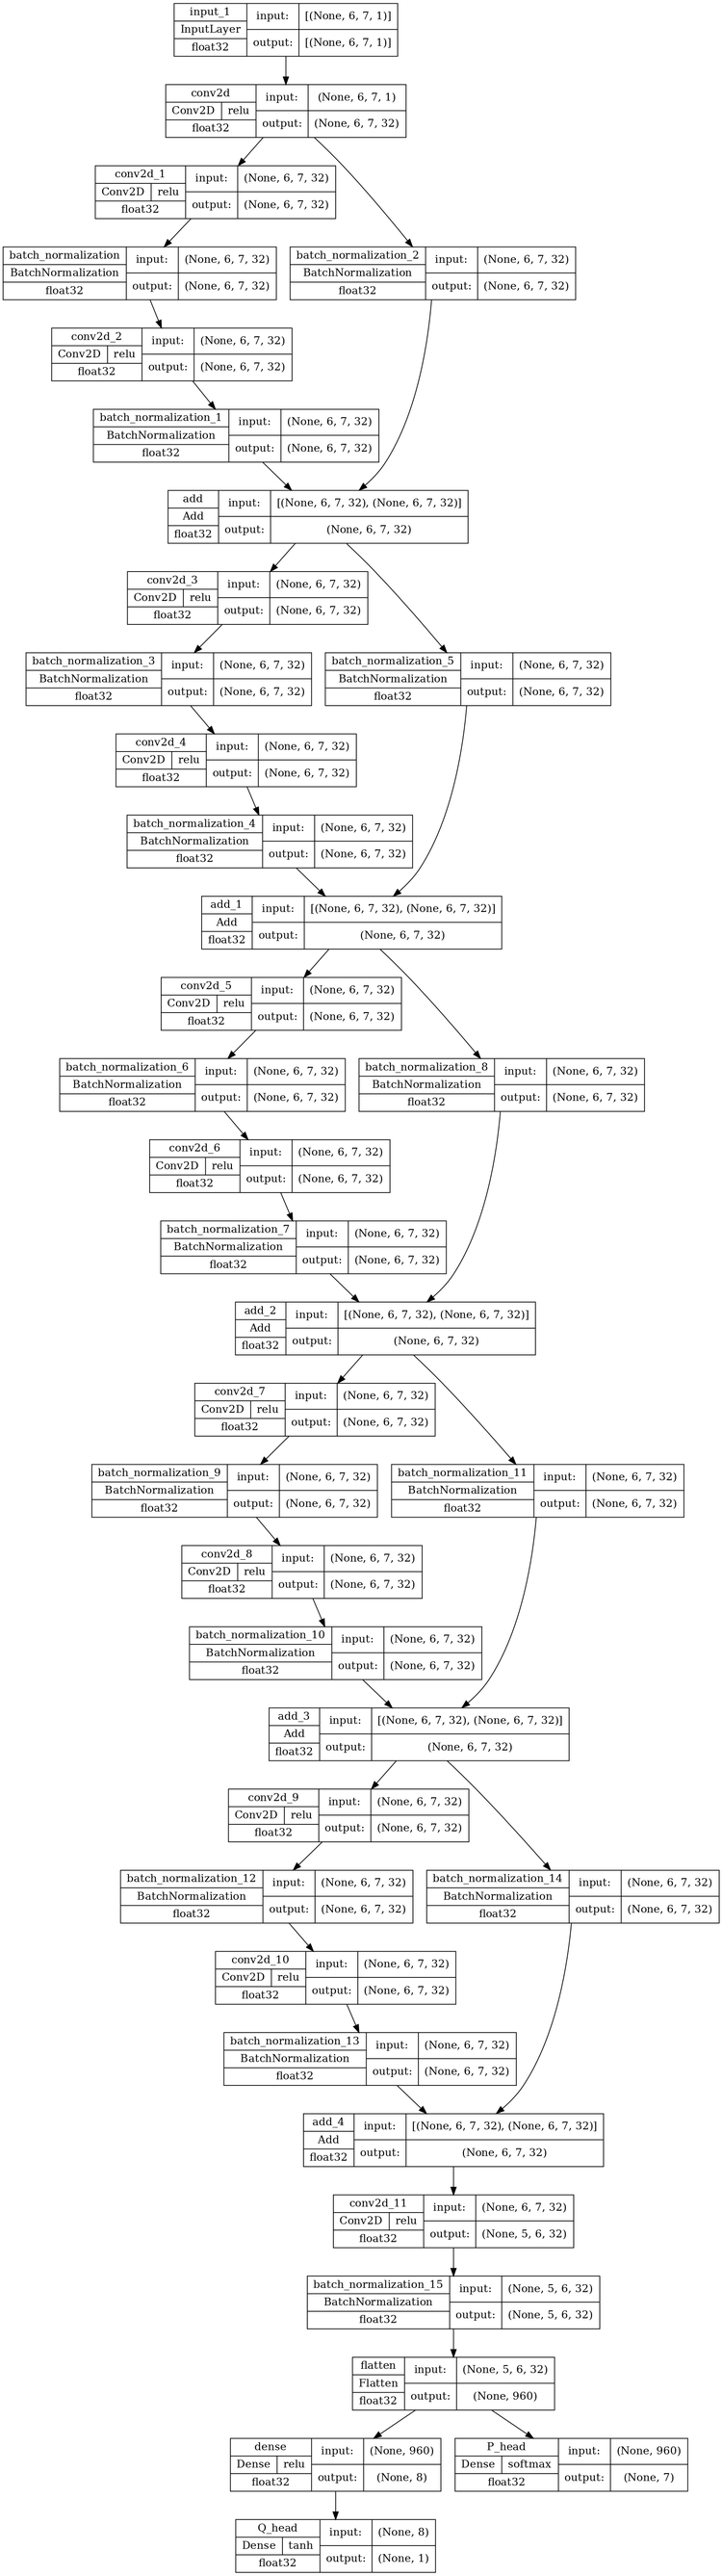

Trainable parameters: 87000
Untrainable parameters: 1024
Total parameters: 88024
==============================Epoch 1 =============================
Training in parallel on 48 cores.


  5%|███▊                                                                             | 1/21 [04:17<1:25:48, 257.43s/it]

In [ ]:
# MAIN TRAIN LOOP
training_episodes = 500
training_epochs = 20
training_epochs_per_epoch = 5
matches = 100
sith_lord_threshold = 1.1
model_complexity = 6
search_nodes = 64
BOOST = 4

agent = A0("Agent",model_complexity, search_nodes)
states, P_target, Q_target = [], [], []
    
for epoch in range(1, training_epochs+1):
    print("==============================Epoch",epoch,"=============================")
    print("Training in parallel on", agent.n_parallel, "cores.")
    for i in tqdm.trange(0,training_episodes,agent.n_parallel*BOOST):
        result_ids = []
        for j in range(agent.n_parallel*BOOST):
            result_ids.append(agent.play_episode.remote(agent, debug = False))
        results = ray.get(result_ids)
        for result in results:
            state_, P_target_, Q_target_ = result
            states.extend(state_); P_target.extend(P_target_); Q_target.extend(Q_target_)

    new_model = agent.fit((states, P_target, Q_target), batch_size = 64, epochs = training_epochs_per_epoch)
    challenger = A0("Challenger", model_complexity, search_nodes, new_model)

    agent_score = 0; challenger_score = 0
    for match in tqdm.trange(0,matches,agent.n_parallel*BOOST):
        result_ids = []
        for j in range(agent.n_parallel*BOOST):
            result_ids.append(play_match.remote(agent, challenger))
        results = ray.get(result_ids)
        for result in results:
            agent_score += result[0]
            challenger_score += result[1]

    print("Challenger score:", challenger_score)
    print("Benchmark score:", agent_score)

    if challenger_score > sith_lord_threshold * agent_score:
        agent.model.set_weights(challenger.model.get_weights())
        agent.model.save('Epoch'+str(epoch)+'.h5')
        challenger.model.save('Epoch'+str(epoch)+'_challenger.h5')
        np.save('Epoch'+str(epoch)+'_states_.npy', np.array(states))
        np.save('Epoch'+str(epoch)+'_P_target_.npy', np.array(P_target))
        np.save('Epoch'+str(epoch)+'_Q_target_.npy', np.array(Q_target))

        del challenger
        states.clear()
        P_target.clear()
        Q_target.clear()

In [ ]:
import psutil
resources = ray.ray.ray.get_resource_ids() 
cpus = [v[0] for v in resources['CPU']]
psutil.Process().cpu_affinity(cpus)

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||0||·||·||·||·|
(play_episode pid=5720) [ 9  9  9  9 10  8  9]
(play_episode pid=5720) [0.14285714 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5720)  0.14285714]


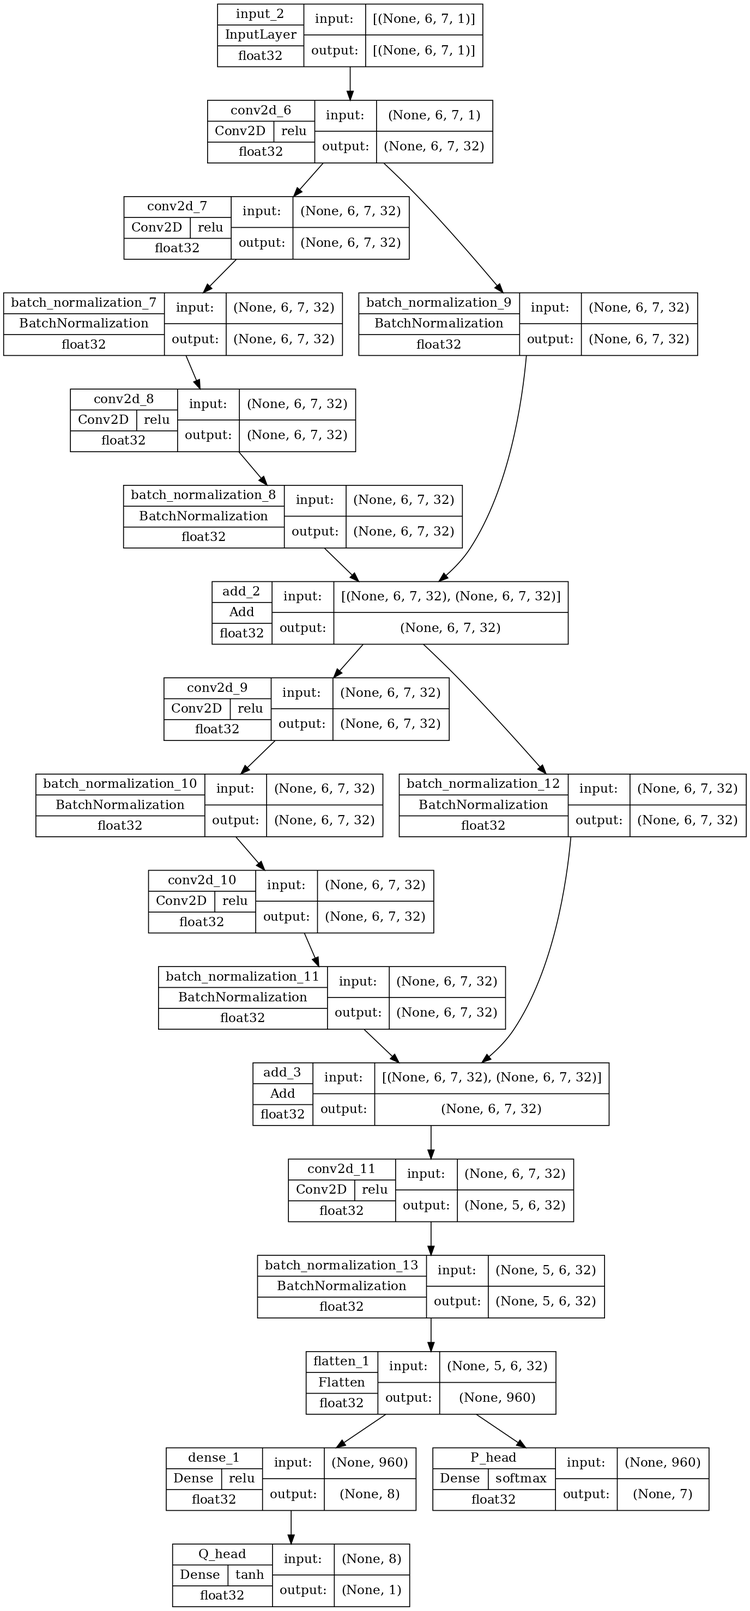

Trainable parameters: 46296
Untrainable parameters: 448
Total parameters: 46744
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) [ 9 10 10  9  8  8  9]
(play_episode pid=5721) [0.14285714 0.15873016 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5721)  0.14285714]
(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||0||·||·||·||·|
(play_episode pid=5720) [ 7  9 10 10 10  8  9]
(play_episode pid=5720) [0.11111111 0.14285714 0.15873016 0.15873016 0.15873016

In [15]:
# DEBUGGING
agent = A0("Agent", 3, 64)

In [ ]:
game = Connect4Game()
turn = 1

times = []
while (game.result() == None):

    for i in range(agent.n_simulations):
        starttime = time.time()

        copy_game = Connect4Game()
        # Pass by copy (we don't want the internal MCTS to modify the outer game)
        copy_game.board = game.board.copy()
        copy_game.tops = game.tops.copy()
        copy_game.moves_played = game.moves_played # integer
        agent.MCTS(copy_game, turn)

        times.append(time.time() - starttime)

    s = (game.board * turn).tobytes()
    move_qualities = np.array([agent.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

    agent.visited.clear() # Reset tree
    print("Turn: ", turn)
    p_, v_ = agent.model((game.board * turn)[np.newaxis, :, :, np.newaxis])
    print("Heuristics:",p_[0], v_[0])
    game.render()
    print(agent.N[s])
    agent.N.clear()
    agent.Q.clear()
    agent.P.clear()

    probs = move_qualities / (np.sum(move_qualities) + 0.00001)
    probs *= (1/np.sum(probs))
    print(probs)
        
    action = np.random.choice(range(0, 7), p = probs)
    game.play(action, turn)

    turn *= -1

print("Average MCTS time:", sum(times) / len(times))

In [ ]:
def play_match(agent, challenger):
    agent_turn = (random.randint(0, 1) * 2) - 1
    print("Agent is playing as", agent_turn)
    game = Connect4Game()
    turn = 1
    while (game.result() == None):
        for i in range(agent.n_simulations):
            starttime = time.time()

            copy_game = Connect4Game()
            copy_game.board = game.board.copy()
            copy_game.tops = game.tops.copy()
            copy_game.moves_played = game.moves_played # integer
            if turn == agent_turn: agent.MCTS(copy_game, turn)
            else: challenger.MCTS(copy_game, turn)

        s = (game.board * turn).tobytes()
        
        print(turn)
        if turn == agent_turn:
            move_qualities = np.array([agent.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])
            print("Agent playing")
            print(move_qualities)
            agent.visited.clear() # Reset tree
            game.render()
            agent.N.clear()
            agent.Q.clear()
            agent.P.clear()

        else:
            move_qualities = np.array([challenger.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])
            print("Challenger playing")
            print(move_qualities)
            challenger.visited.clear() # Reset tree
            game.render()
            challenger.N.clear()
            challenger.Q.clear()
            challenger.P.clear()

        probs = move_qualities / (np.sum(move_qualities) + 0.00001)
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        game.play(action, turn)

        turn *= -1
    if game.result() == agent_turn:
        print("Agent wins!")
        return (1,0)
    elif game.result() == -agent_turn:
        print("Challenger wins!")
        return (0,1)
    else:
        print("It's a draw!")
        return (0.5,0.5)

In [ ]:
for i in tqdm.trange(0,1,agent.n_parallel):
    result_ids = []
    for j in range(agent.n_parallel):
        result_ids.append(agent.play_episode.remote(agent, debug = False))
    results = ray.get(result_ids)
    for result in results:
        state_, P_target_, Q_target_ = result
        states.extend(state_); P_target.extend(P_target_); Q_target.extend(Q_target_)

In [ ]:
new_model = agent.fit((states, P_target, Q_target), batch_size = 64, epochs = 3)
challenger = A0("Challenger", model_complexity, search_nodes, new_model)

In [ ]:
play_match(agent, challenger)

In [8]:
training_episodes = 1
for i in tqdm.trange(training_episodes):
    agent.play_episode.remote(agent,debug = True)

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ram://b66be46e-69d2-4625-9bc8-4585081eab90/assets


INFO:tensorflow:Assets written to: ram://b66be46e-69d2-4625-9bc8-4585081eab90/assets
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]
(play_episode pid=5720) 2022-11-08 08:16:08.695630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5720) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5720) 2022-11-08 08:16:08.822325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5720) 2022-11-08 08:16:08.822354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not hav

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) [ 9  9  8 11 10  8  8]
(play_episode pid=5720) [0.14285714 0.14285714 0.12698413 0.17460317 0.15873016 0.12698413
(play_episode pid=5720)  0.12698413]


(play_episode pid=5720) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5720) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||0|
(play_episode pid=5720) [ 9  9  9 11 10  8  7]
(play_episode pid=5720) [0.14285714 0.14285714 0.14285714 0.17460317 0.15873016 0.12698413
(play_episode pid=5720)  0.11111111]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||0|
(play_episode pid=5720) [ 8  9  8 11 10  9  8]
(play_episode pid=5720) [0.12698413 0.14285714 0.12698413 0.17460317 0.15873016 0.14285714
(play_episode pid=5720)  0.12698413]
(play_episode pid=5720) Turn:  

(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||0||·|
(play_episode pid=5720) |·||·||·||·||O||0||·|
(play_episode pid=5720) |·||·||·||·||0||O||·|
(play_episode pid=5720) |O||·||·||·||O||O||0|
(play_episode pid=5720) |0||O||·||0||O||0||0|
(play_episode pid=5720) [11  8  9  8 10  9  8]
(play_episode pid=5720) [0.17460317 0.12698413 0.14285714 0.12698413 0.15873016 0.14285714
(play_episode pid=5720)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||O||·|
(play_episode pid=5720) |·||·||·||·||·||0||·|
(play_episode pid=5720) |·||·||·||·||O||0||·|
(play_episode pid=5720) |·||·||·||·||0||O||·|
(play_episode pid=5720) |O||·||·||·||O||O||0|
(play_episode pid=5720) |0||O||·||0||O||0||0|
(play_episode pid=5720) [11 11  8 13 12  0  8]
(play_episode pid=5720) [0.17460317 0.17460317 0.12698413 0.20634921 0.19047619 0.
(play_episode pid=5720)  0.12698413]
(play_episode pid=5720) Turn:  -1
(play

In [16]:
start_time = time.time()
result_ids = []
for i in range(agent.n_parallel):
    result_ids.append(agent.play_episode.remote(agent, debug = True))
results = ray.get(result_ids)
print("Total time:", time.time() - start_time)

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||0||O||·||·||·|
(play_episode pid=5720) [ 9  9  8  9 11  8  9]
(play_episode pid=5720) [0.14285714 0.14285714 0.12698413 0.14285714 0.17460317 0.12698413
(play_episode pid=5720)  0.14285714]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||·||·||·|
(play_episode pid=5721) |O||O||0||·||0||·||·|
(play_episode pid=5721) [9 9 9 9 9 9 9]
(play_episode pid=5721) [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
(play_episode pid=5721)  0.14285714]


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||0||O||·||·||0|
(play_episode pid=5720) [ 8  9  9 10 11  8  8]
(play_episode pid=5720) [0.12698413 0.14285714 0.14285714 0.15873016 0.17460317 0.12698413
(play_episode pid=5720)  0.12698413]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||·||·|
(play_episode pid=5721) [ 8 10  9 10  8  9  9]
(play_episode pid=5721) [0.12698413 0.15873016 0.14285714 0.15873016 0.12698413 0.14285714
(play_episode pid=5721)  0.14285714]
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://1b5fd398-d608-4e44-9afa-87c67ca6cbe9/assets
(play_episode pid=5684) 2022-11-08 08:19:02.907819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5684) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5684) 2022-11-08 08:19:03.034698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5684) 2022-11-08 08:19:03.034729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5684) 2022-11-08 08:19:03.064655: E tensorflow/stream_executor/cuda/cud

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||O|
(play_episode pid=5720) |O||·||0||O||·||·||0|
(play_episode pid=5720) [ 9  8  9  9 10  9  9]
(play_episode pid=5720) [0.14285714 0.12698413 0.14285714 0.14285714 0.15873016 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||·||·|
(play_episode pid=5721) [ 8 10  9 10  9  9  8]
(play_episode pid=5721) [0.12698413 0.15873016 0.14285714 0.15873016 0.14285714 0.14285714
(play_episode pid=5721)  0.12698413]


(play_episode pid=5684) 2022-11-08 08:19:03.673358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5684) 2022-11-08 08:19:03.673413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5684) 2022-11-08 08:19:03.673420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||O|
(play_episode pid=5720) |O||0||0||O||·||·||0|
(play_episode pid=5720) [ 8  9  9  9 10  9  9]
(play_episode pid=5720) [0.12698413 0.14285714 0.14285714 0.14285714 0.15873016 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||0||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||·||·|
(play_episode pid=5721) [ 3  3  3  3 45  3  3]
(play_episode pid=5721) [0.04761905 0.04761905 0.04761905 0.04761905 0.71428571 0.04761905
(play_episode pid=5721)  0.04761905]


(play_episode pid=5684) 2022-11-08 08:19:04.485932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5684) 2022-11-08 08:19:04.485964: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5684) 2022-11-08 08:19:04.485983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5684) 2022-11-08 08:19:04.486155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5684) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

INFO:tensorflow:Assets written to: ram://2cae61da-a30d-47e9-a04c-1d40a1f17245/assets


INFO:tensorflow:Assets written to: ram://2cae61da-a30d-47e9-a04c-1d40a1f17245/assets


(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||O|
(play_episode pid=5720) |O||0||0||O||·||O||0|
(play_episode pid=5720) [ 9  7  9  9 11  9  9]
(play_episode pid=5720) [0.14285714 0.11111111 0.14285714 0.14285714 0.17460317 0.14285714
(play_episode pid=5720)  0.14285714]


(play_episode pid=5678) 2022-11-08 08:19:05.250221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5678) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5678) 2022-11-08 08:19:05.387856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5678) 2022-11-08 08:19:05.387887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5678) 2022-11-08 08:19:05.418549: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||·|
(play_episode pid=5721) |·||·||O||·||0||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||·||·|
(play_episode pid=5721) [ 9 10  9  9  8  9  9]
(play_episode pid=5721) [0.14285714 0.15873016 0.14285714 0.14285714 0.12698413 0.14285714
(play_episode pid=5721)  0.14285714]


(play_episode pid=5678) 2022-11-08 08:19:06.064966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5678) 2022-11-08 08:19:06.065036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5678) 2022-11-08 08:19:06.065359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||0||·||·||O|
(play_episode pid=5720) |O||0||0||O||·||O||0|
(play_episode pid=5720) [ 8 10  7  9 10  9 10]
(play_episode pid=5720) [0.12698413 0.15873016 0.11111111 0.14285714 0.15873016 0.14285714
(play_episode pid=5720)  0.15873016]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) [10  9  9  9 10  8  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5684)  0.12698413]


(play_episode pid=5684) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5684) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||·|
(play_episode pid=5721) |·||·||O||·||0||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||0||·|
(play_episode pid=5721) [ 3  4  4 40  3  5  4]
(play_episode pid=5721) [0.04761905 0.06349206 0.06349206 0.63492063 0.04761905 0.07936508
(play_episode pid=5721)  0.06349206]


(play_episode pid=5678) 2022-11-08 08:19:06.870665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5678) 2022-11-08 08:19:06.870696: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5678) 2022-11-08 08:19:06.870713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5678) 2022-11-08 08:19:06.870938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5678) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||·|
(play_episode pid=5721) |·||·||O||·||0||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) |O||O||0||·||0||0||O|
(play_episode pid=5721) [ 1  1  0 58  1  1  1]
(play_episode pid=5721) [0.01587302 0.01587302 0.         0.92063492 0.01587302 0.01587302
(play_episode pid=5721)  0.01587302]
(play_episode pid=5721) Average MCTS time: 0.016263053967402533
INFO:tensorflow:Assets written to: ram://b994fca3-3e43-4707-80ea-02f6c0068d33/assets


INFO:tensorflow:Assets written to: ram://b994fca3-3e43-4707-80ea-02f6c0068d33/assets


(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||O||·||·||·|
(play_episode pid=5720) |0||·||·||0||·||·||O|
(play_episode pid=5720) |O||0||0||O||·||O||0|
(play_episode pid=5720) [ 9  8 10  8 10  9  9]
(play_episode pid=5720) [0.14285714 0.12698413 0.15873016 0.12698413 0.15873016 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||0||·||·|
(play_episode pid=5684) [11 10 10  9  8  8  7]
(play_episode pid=5684) [0.17460317 0.15873016 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5684)  0.11111111]
(play_episode pid=5720) Turn:  

(play_episode pid=5678) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5678) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(play_episode pid=5721) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) [10  9  9  9 10  8  8]
(play_episode pid=5721) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||·||O||0||·||·|
(play_episode pid=5684) [11  9 10  9  8  9  7]
(play_episode pid=5684) [0.17460317 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5684)  0.11111111]
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: ram://4cc406e9-f2b0-4cdb-b299-ca8f1fca7329/assets
(play_episode pid=5717) 2022-11-08 08:19:10.063606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5717) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||0||·||·||·|
(play_episode pid=5720) |·||·||·||O||·||·||·|
(play_episode pid=5720) |0||·||0||0||·||·||O|
(play_episode pid=5720) |O||0||0||O||O||O||0|
(play_episode pid=5720) [ 8 17  8  8  7  7  8]
(play_episode pid=5720) [0.12698413 0.26984127 0.12698413 0.12698413 0.11111111 0.11111111
(play_episode pid=5720)  0.12698413]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||·||·||·||·||·|
(play_episode pid=5678) [11  8  9  9  9  9  8]
(play_episode pid=5678) [0.17460317 0.12698413 0.14285714 0.14285714 0.14285714 0.14285714
(play_episode pid=5678)  0.12698413]


(play_episode pid=5717) 2022-11-08 08:19:10.205231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5717) 2022-11-08 08:19:10.205262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5717) 2022-11-08 08:19:10.236417: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||0||·||·||·|
(play_episode pid=5720) |·||·||·||O||·||·||O|
(play_episode pid=5720) |0||·||0||0||·||·||O|
(play_episode pid=5720) |O||0||0||O||O||O||0|
(play_episode pid=5720) [ 1 57  1  1  1  1  1]
(play_episode pid=5720) [0.01587302 0.9047619  0.01587302 0.01587302 0.01587302 0.01587302
(play_episode pid=5720)  0.01587302]
(play_episode pid=5720) Average MCTS time: 0.01559894805153211
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||0|
(play_episode pid=5721) [10  8  9 10 10  8  8]
(play_episode pid=5721) [0.15873016 0.12698413 0.14285714 0.15873016 0.15873016 0.12698413
(play

(play_episode pid=5717) 2022-11-08 08:19:10.820117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5717) 2022-11-08 08:19:10.820184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5717) 2022-11-08 08:19:10.820193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||·|
(play_episode pid=5684) |0||·||·||O||0||·||·|
(play_episode pid=5684) [10  9  9 10  8  9  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.15873016 0.12698413 0.14285714
(play_episode pid=5684)  0.12698413]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||·||·||·||O||·|
(play_episode pid=5678) [11  9  9  9 10  7  8]
(play_episode pid=5678) [0.17460317 0.14285714 0.14285714 0.14285714 0.15873016 0.11111111
(play_episode pid=5678)  0.12698413]


(play_episode pid=5717) 2022-11-08 08:19:11.654858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5717) 2022-11-08 08:19:11.654890: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5717) 2022-11-08 08:19:11.654908: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5717) 2022-11-08 08:19:11.655081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5717) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||0|
(play_episode pid=5721) [10  8  9  8  9  9 10]
(play_episode pid=5721) [0.15873016 0.12698413 0.14285714 0.12698413 0.14285714 0.14285714
(play_episode pid=5721)  0.15873016]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |0||·||·||O||0||·||·|
(play_episode pid=5684) [10  8  9 12  8  9  7]
(play_episode pid=5684) [0.15873016 0.12698413 0.14285714 0.19047619 0.12698413 0.14285714
(play_episode pid=5684)  0.11111111]
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: ram://91d6d347-506f-42c6-95cf-4df5ce68e0f4/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||·||·||0||O||·|
(play_episode pid=5678) [12  8  9 10  8  8  8]
(play_episode pid=5678) [0.19047619 0.12698413 0.14285714 0.15873016 0.12698413 0.12698413
(play_episode pid=5678)  0.12698413]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||0||0|
(play_episode pid=5721) [11  8  9 11  8  8  8]
(play_episode pid=5721) [0.17460317 0.12698413 0.14285714 0.17460317 0.12698413 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn: 

(play_episode pid=5717) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5717) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||·|
(play_episode pid=5721) |·||·||·||·||O||0||0|
(play_episode pid=5721) [12  8 10 10  7  8  8]
(play_episode pid=5721) [0.19047619 0.12698413 0.15873016 0.15873016 0.11111111 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [10  9  9 12  8  7  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.19047619 0.12698413 0.11111111
(play_episode pid=5684)  0.12698413]
(play_episode pid=5720) Turn:  

(play_episode pid=5720) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5720) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://4c7b42db-419b-4c02-a746-a4e1e3e4d87f/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||·||·||·|
(play_episode pid=5678) |0||·||·||O||0||O||·|
(play_episode pid=5678) [10  8  9 13  7  8  8]
(play_episode pid=5678) [0.15873016 0.12698413 0.14285714 0.20634921 0.11111111 0.12698413
(play_episode pid=5678)  0.12698413]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||0||·||·||·||·|
(play_episode pid=5717) [10  9 11  9  9  8  7]
(play_episode pid=5717) [0.15873016 0.14285714 0.17460317 0.14285714 0.14285714 0.12698413
(play_episode pid=5717)  0.11111111]


(play_episode pid=5680) 2022-11-08 08:19:14.894976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5680) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5680) 2022-11-08 08:19:15.057218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5680) 2022-11-08 08:19:15.057261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5680) 2022-11-08 08:19:15.092155: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for

(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||O||·||·|
(play_episode pid=5721) |·||·||0||·||O||0||0|
(play_episode pid=5721) [11  9  9 11  8  7  8]
(play_episode pid=5721) [0.17460317 0.14285714 0.14285714 0.17460317 0.12698413 0.11111111
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [ 5  5  5 34  5  5  4]
(play_episode pid=5684) [0.07936508 0.07936508 0.07936508 0.53968254 0.07936508 0.07936508
(play_episode pid=5684)  0.06349206]
(play_episode pid=5720) Turn:  

(play_episode pid=5680) 2022-11-08 08:19:15.734201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5680) 2022-11-08 08:19:15.734258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5680) 2022-11-08 08:19:15.734264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||0||·||O||·||·|
(play_episode pid=5717) [10  9  9 10  9  8  8]
(play_episode pid=5717) [0.15873016 0.14285714 0.14285714 0.15873016 0.14285714 0.12698413
(play_episode pid=5717)  0.12698413]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||O||·||·|
(play_episode pid=5721) |·||·||0||·||O||0||0|
(play_episode pid=5721) [12  9  8 10  7  9  8]
(play_episode pid=5721) [0.19047619 0.14285714 0.12698413 0.15873016 0.11111111 0.14285714
(play_episode pid=5721)  0.12698413]


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||0||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [12  9  9  9  8  8  8]
(play_episode pid=5684) [0.19047619 0.14285714 0.14285714 0.14285714 0.12698413 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) [10  9 10  9  8  9  8]
(play_episode pid=5720) [0.15873016 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5720)  0.12698413]


(play_episode pid=5680) 2022-11-08 08:19:16.602664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5680) 2022-11-08 08:19:16.602695: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5680) 2022-11-08 08:19:16.602713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5680) 2022-11-08 08:19:16.602914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5680) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||0||·||·|
(play_episode pid=5678) |0||·||O||O||0||O||·|
(play_episode pid=5678) [11  8 10 10  7  8  9]
(play_episode pid=5678) [0.17460317 0.12698413 0.15873016 0.15873016 0.11111111 0.12698413
(play_episode pid=5678)  0.14285714]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||0||0||O||·||·|
(play_episode pid=5717) [11  8 10  7  9 10  8]
(play_episode pid=5717) [0.17460317 0.12698413 0.15873016 0.11111111 0.14285714 0.15873016
(play_episode pid=5717)  0.12698413]
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://528ff075-387c-454e-9479-685332692659/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||O||·||O||·||·|
(play_episode pid=5721) |·||·||0||·||O||0||0|
(play_episode pid=5721) [18  8  6  8  8  7  8]
(play_episode pid=5721) [0.28571429 0.12698413 0.0952381  0.12698413 0.12698413 0.11111111
(play_episode pid=5721)  0.12698413]


(play_episode pid=5696) 2022-11-08 08:19:17.468610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5696) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5696) 2022-11-08 08:19:17.606050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5696) 2022-11-08 08:19:17.606079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||0||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||·|
(play_episode pid=5684) |·||O||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [ 8 12  6  8 14  8  7]
(play_episode pid=5684) [0.12698413 0.19047619 0.0952381  0.12698413 0.22222222 0.12698413
(play_episode pid=5684)  0.11111111]


(play_episode pid=5696) 2022-11-08 08:19:17.637856: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||0||·||·|
(play_episode pid=5720) [10 11 10  9  8  8  7]
(play_episode pid=5720) [0.15873016 0.17460317 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5720)  0.11111111]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||0||·||·|
(play_episode pid=5678) |0||O||O||O||0||O||·|
(play_episode pid=5678) [10  9 11 10  8  7  8]
(play_episode pid=5678) [0.15873016 0.14285714 0.17460317 0.15873016 0.12698413 0.11111111
(play_episode pid=5678)  0.12698413]
(play_episode pid=5717) Turn:  

(play_episode pid=5696) 2022-11-08 08:19:18.258289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5696) 2022-11-08 08:19:18.258349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5696) 2022-11-08 08:19:18.258356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||O||·||O||·||·|
(play_episode pid=5721) |O||·||0||·||O||0||0|
(play_episode pid=5721) [13  7  9  9  8 10  7]
(play_episode pid=5721) [0.20634921 0.11111111 0.14285714 0.14285714 0.12698413 0.15873016
(play_episode pid=5721)  0.11111111]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||0||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |·||O||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [ 8  8  8  8 15  7  9]
(play_episode pid=5684) [0.12698413 0.12698413 0.12698413 0.12698413 0.23809524 0.11111111
(play_episode pid=5684)  0.14285714]
(play_episode pid=5680) Turn:  

(play_episode pid=5680) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5680) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(play_episode pid=5696) 2022-11-08 08:19:19.138408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5696) 2022-11-08 08:19:19.138443: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5696) 2022-

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||0||·||·|
(play_episode pid=5720) [10  7  9 10  8 10  9]
(play_episode pid=5720) [0.15873016 0.11111111 0.14285714 0.15873016 0.12698413 0.15873016
(play_episode pid=5720)  0.14285714]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||·|
(play_episode pid=5684) |·||·||·||0||·||·||·|
(play_episode pid=5684) |·||·||·||O||0||·||·|
(play_episode pid=5684) |·||O||·||O||0||·||·|
(play_episode pid=5684) |0||O||·||O||0||0||·|
(play_episode pid=5684) [ 2  1  0  1 57  1  1]
(play_episode pid=5684) [0.03174603 0.01587302 0.         0.01587302 0.9047619  0.01587302
(play_episode pid=5684)  0.01587302]
(play_episode pid=5684) Average 

INFO:tensorflow:Assets written to: ram://4f9d4213-505a-4c41-8826-ef12fa47b3b0/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||O||·||O||·||·|
(play_episode pid=5721) |O||·||0||·||O||0||0|
(play_episode pid=5721) [15  9  6  8  9  8  8]
(play_episode pid=5721) [0.23809524 0.14285714 0.0952381  0.12698413 0.14285714 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||0||·|
(play_episode pid=5680) [10  9 10  9 10  7  8]
(play_episode pid=5680) [0.15873016 0.14285714 0.15873016 0.14285714 0.15873016 0.11111111
(play_episode pid=5680)  0.12698413]
(play_episode pid=5720) Turn: 

(play_episode pid=5696) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5696) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||O||0||·||·|
(play_episode pid=5720) [11  8  9  7  9 10  9]
(play_episode pid=5720) [0.17460317 0.12698413 0.14285714 0.11111111 0.14285714 0.15873016
(play_episode pid=5720)  0.14285714]


(play_episode pid=5684) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5684) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||·||·||·|
(play_episode pid=5678) |O||·||·||0||0||·||·|
(play_episode pid=5678) |0||O||O||O||0||O||0|
(play_episode pid=5678) [10 11 11  8  7  8  8]
(play_episode pid=5678) [0.15873016 0.17460317 0.17460317 0.12698413 0.11111111 0.12698413
(play_episode pid=5678)  0.12698413]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) [10  9  9  9 10  8  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5717) Turn:  

INFO:tensorflow:Assets written to: ram://ce5bc3b2-017a-4adf-82b6-d32f113c6a54/assets


(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) [11  8  9  9  9  9  8]
(play_episode pid=5696) [0.17460317 0.12698413 0.14285714 0.14285714 0.14285714 0.14285714
(play_episode pid=5696)  0.12698413]


(play_episode pid=5707) 2022-11-08 08:19:22.497943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5707) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5707) 2022-11-08 08:19:22.633674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5707) 2022-11-08 08:19:22.633704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5707) 2022-11-08 08:19:22.664570: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for

(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||0||0||O||0||·||·|
(play_episode pid=5720) [11  8 10  9  8  9  8]
(play_episode pid=5720) [0.17460317 0.12698413 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5720)  0.12698413]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||·||·||·|
(play_episode pid=5678) |O||·||·||0||0||·||O|
(play_episode pid=5678) |0||O||O||O||0||O||0|
(play_episode pid=5678) [ 8  8 10 10  8  8 11]
(play_episode pid=5678) [0.12698413 0.12698413 0.15873016 0.15873016 0.12698413 0.12698413
(play_episode pid=5678)  0.17460317]
(play_episode pid=5684) Turn:  

(play_episode pid=5707) 2022-11-08 08:19:23.305722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5707) 2022-11-08 08:19:23.305780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5707) 2022-11-08 08:19:23.305787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||O||·||·||·|
(play_episode pid=5696) [10 10  9  8 10  8  8]
(play_episode pid=5696) [0.15873016 0.15873016 0.14285714 0.12698413 0.15873016 0.12698413
(play_episode pid=5696)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||O||·||·|
(play_episode pid=5720) |·||0||0||O||0||·||·|
(play_episode pid=5720) [11  7  9  8 10 10  8]
(play_episode pid=5720) [0.17460317 0.11111111 0.14285714 0.12698413 0.15873016 0.15873016
(play_episode pid=5720)  0.12698413]


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||0||·||·|
(play_episode pid=5678) |O||·||·||0||0||·||O|
(play_episode pid=5678) |0||O||O||O||0||O||0|
(play_episode pid=5678) [ 8  8  8  9 13  9  8]
(play_episode pid=5678) [0.12698413 0.12698413 0.12698413 0.14285714 0.20634921 0.14285714
(play_episode pid=5678)  0.12698413]


(play_episode pid=5707) 2022-11-08 08:19:24.213569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5707) 2022-11-08 08:19:24.213601: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5707) 2022-11-08 08:19:24.213618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5707) 2022-11-08 08:19:24.213786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5707) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||O||·||·||·||·||·|
(play_episode pid=5684) |·||0||·||·||·||·||·|
(play_episode pid=5684) [10  9 10  9  8  9  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5684)  0.12698413]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||0||0||·||·|
(play_episode pid=5678) |O||·||O||0||0||·||O|
(play_episode pid=5678) |0||O||O||O||0||O||0|
(play_episode pid=5678) [ 1  1  1  1 57  1  1]
(play_episode pid=5678) [0.01587302 0.01587302 0.01587302 0.01587302 0.9047619  0.01587302
(play_episode pid=5678)  0.01587302]
(play_episode pid=5678) Average 

INFO:tensorflow:Assets written to: ram://84ed2adb-8ff8-4558-b27d-656ea714e894/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||O||·||0||·||·|
(play_episode pid=5721) |·||·||O||O||O||0||·|
(play_episode pid=5721) |O||·||0||0||O||0||0|
(play_episode pid=5721) [10  7  8  5  8 18  7]
(play_episode pid=5721) [0.15873016 0.11111111 0.12698413 0.07936508 0.12698413 0.28571429
(play_episode pid=5721)  0.11111111]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||O||0||·||·|
(play_episode pid=5696) [11  9 10  9  8  9  7]
(play_episode pid=5696) [0.17460317 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5696)  0.11111111]
(play_episode pid=5720) Turn: 

(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||O||·||·||·||·||·|
(play_episode pid=5684) |·||0||·||O||·||·||0|
(play_episode pid=5684) [10  9  9  8  8  9 10]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.12698413 0.12698413 0.14285714
(play_episode pid=5684)  0.15873016]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||0||·||·||·|
(play_episode pid=5717) |·||·||0||0||·||·||0|
(play_episode pid=5717) |O||·||0||0||O||O||O|
(play_episode pid=5717) [10  7  7 12  6 14  7]
(play_episode pid=5717) [0.15873016 0.11111111 0.11111111 0.19047619 0.0952381  0.22222222
(play_episode pid=5717)  0.11111111]
(play_episode pid=5721) Turn:  

(play_episode pid=5678) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5678) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://5cbb1e3d-d96b-4562-b195-fd4bc931e655/assets


(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||0||·||·|
(play_episode pid=5707) [11 10 10  9  8  8  7]
(play_episode pid=5707) [0.17460317 0.15873016 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5707)  0.11111111]
(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||·||·||·||·||·|
(play_episode pid=5720) |·||O||O||0||O||·||·|
(play_episode pid=5720) |·||0||0||O||0||·||·|
(play_episode pid=5720) [ 3  4 40  5  4  3  4]
(play_episode pid=5720) [0.04761905 0.06349206 0.63492063 0.07936508 0.06349206 0.04761905
(play_episode pid=5720)  0.06349206]


(play_episode pid=5725) 2022-11-08 08:19:27.523638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5725) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5725) 2022-11-08 08:19:27.686638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5725) 2022-11-08 08:19:27.686679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5725) 2022-11-08 08:19:27.724824: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for

(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||·||·||0||·||·|
(play_episode pid=5721) |·||·||O||·||0||O||·|
(play_episode pid=5721) |O||·||O||O||O||0||·|
(play_episode pid=5721) |O||0||0||0||O||0||0|
(play_episode pid=5721) [ 2 54  1  2  1  2  1]
(play_episode pid=5721) [0.03174603 0.85714286 0.01587302 0.03174603 0.01587302 0.03174603
(play_episode pid=5721)  0.01587302]
(play_episode pid=5721) Average MCTS time: 0.016902997054987483
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||O||·||·||·||·||0|
(play_episode pid=5684) |·||0||·||O||·||·||0|
(play_episode pid=5684) [ 9 10 10  7 10  9  8]
(play_episode pid=5684) [0.14285714 0.15873016 0.15873016 0.11111111 0.15873016 0.14285714
(pl

(play_episode pid=5725) 2022-11-08 08:19:28.378980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5725) 2022-11-08 08:19:28.379052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5725) 2022-11-08 08:19:28.379061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||O||·||0||·||·|
(play_episode pid=5707) [10  9 10  9  8  9  8]
(play_episode pid=5707) [0.15873016 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5707)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||O||·||·||·||·|
(play_episode pid=5720) |·||O||O||0||O||·||·|
(play_episode pid=5720) |·||0||0||O||0||·||·|
(play_episode pid=5720) [11  8  8  8 10  9  9]
(play_episode pid=5720) [0.17460317 0.12698413 0.12698413 0.12698413 0.15873016 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5684) Turn:  1

(play_episode pid=5725) 2022-11-08 08:19:29.254967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5725) 2022-11-08 08:19:29.255003: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5725) 2022-11-08 08:19:29.255023: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5725) 2022-11-08 08:19:29.255210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5725) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||O||·||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [10  9  8 11  8  7 10]
(play_episode pid=5680) [0.15873016 0.14285714 0.12698413 0.17460317 0.12698413 0.11111111
(play_episode pid=5680)  0.15873016]
(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |O||·||·||0||·||·||·|
(play_episode pid=5717) |O||·||0||0||·||0||0|
(play_episode pid=5717) |O||·||0||0||O||O||O|
(play_episode pid=5717) [ 1  1  1  1 57  1  1]
(play_episode pid=5717) [0.01587302 0.01587302 0.01587302 0.01587302 0.9047619  0.01587302
(play_episode pid=5717)  0.01587302]
(play_episode pid=5696) Turn:  

INFO:tensorflow:Assets written to: ram://8278c22a-7a07-4b04-8b58-bd72973475be/assets


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||O||·||·||·||·|
(play_episode pid=5720) |·||O||O||0||O||·||·|
(play_episode pid=5720) |·||0||0||O||0||0||·|
(play_episode pid=5720) [ 9  6 13 14  8  7  6]
(play_episode pid=5720) [0.14285714 0.0952381  0.20634921 0.22222222 0.12698413 0.11111111
(play_episode pid=5720)  0.0952381 ]
(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||O|
(play_episode pid=5684) |·||O||·||·||·||·||0|
(play_episode pid=5684) |0||0||·||O||·||·||0|
(play_episode pid=5684) [10 10 10  8  9 10  6]
(play_episode pid=5684) [0.15873016 0.15873016 0.15873016 0.12698413 0.14285714 0.15873016
(play_episode pid=5684)  0.0952381 ]
(play_episode pid=5680) Turn: 

(play_episode pid=5725) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5725) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||O||·||·||·|
(play_episode pid=5680) |·||·||·||O||·||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [11  9  9  7  8  8 11]
(play_episode pid=5680) [0.17460317 0.14285714 0.14285714 0.11111111 0.12698413 0.12698413
(play_episode pid=5680)  0.17460317]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||0|
(play_episode pid=5678) |·||·||O||·||·||O||0|
(play_episode pid=5678) [12  9  9  9  9  7  8]
(play_episode pid=5678) [0.19047619 0.14285714 0.14285714 0.14285714 0.14285714 0.11111111
(play_episode pid=5678)  0.12698413]
(play_episode pid=5696) Turn:  

(play_episode pid=5717) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5717) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://fee2701b-dbcb-466c-b947-58f198a1af99/assets


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||O||·||·||·||·|
(play_episode pid=5720) |·||O||O||0||O||O||·|
(play_episode pid=5720) |0||0||0||O||0||0||·|
(play_episode pid=5720) [ 8  6 11 18  8  6  6]
(play_episode pid=5720) [0.12698413 0.0952381  0.17460317 0.28571429 0.12698413 0.0952381
(play_episode pid=5720)  0.0952381 ]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||0|
(play_episode pid=5725) [10  8  9 10 10  8  8]
(play_episode pid=5725) [0.15873016 0.12698413 0.14285714 0.15873016 0.15873016 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5684) Turn:  

(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||·||·||·||·||O|
(play_episode pid=5707) |0||O||O||·||0||·||0|
(play_episode pid=5707) [ 8 10  9 10  8  8 10]
(play_episode pid=5707) [0.12698413 0.15873016 0.14285714 0.15873016 0.12698413 0.12698413
(play_episode pid=5707)  0.15873016]
(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||O||·||·||·||·||0|
(play_episode pid=5717) [10 10  9  8  9  8  9]
(play_episode pid=5717) [0.15873016 0.15873016 0.14285714 0.12698413 0.14285714 0.12698413
(play_episode pid=5717)  0.14285714]


(play_episode pid=5721) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5721) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) [10  9  9  9 10  8  8]
(play_episode pid=5721) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||O||O||0||·||·||·|
(play_episode pid=5720) |·||O||O||0||O||O||·|
(play_episode pid=5720) |0||0||0||O||0||0||O|
(play_episode pid=5720) [ 9  7 15  9  7  8  8]
(play_episode pid=5720) [0.14285714 0.11111111 0.23809524 0.14285714 0.11111111 0.12698413
(play_episode pid=5720)  0.12698413]
(play_episode pid=5725) Turn:  

INFO:tensorflow:Assets written to: ram://b27dda23-ded9-4a1c-a784-16a2a1230a49/assets


(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||O||·||·||·|
(play_episode pid=5680) |O||·||·||O||O||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [ 8  9  8 10 10 10  8]
(play_episode pid=5680) [0.12698413 0.14285714 0.12698413 0.15873016 0.15873016 0.15873016
(play_episode pid=5680)  0.12698413]


(play_episode pid=5682) 2022-11-08 08:19:35.452979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5682) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(play_episode pid=5682) 2022-11-08 08:19:35.611733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5682) 2022-11-08 08:19:35.611769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||O||·||·|
(play_episode pid=5696) |0||O||·||·||O||·||·|
(play_episode pid=5696) |0||O||·||O||0||0||·|
(play_episode pid=5696) [ 9 10 10  9  9  9  7]
(play_episode pid=5696) [0.14285714 0.15873016 0.15873016 0.14285714 0.14285714 0.14285714
(play_episode pid=5696)  0.11111111]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||·||·||·||O||0|
(play_episode pid=5678) |0||·||O||·||·||O||0|
(play_episode pid=5678) [ 8  8  8 12  9  9  9]
(play_episode pid=5678) [0.12698413 0.12698413 0.12698413 0.19047619 0.14285714 0.14285714
(play_episode pid=5678)  0.14285714]


(play_episode pid=5682) 2022-11-08 08:19:35.644671: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||O||·||·||·||O|
(play_episode pid=5707) |0||O||O||·||0||·||0|
(play_episode pid=5707) [19  8  7  7  7  8  7]
(play_episode pid=5707) [0.3015873  0.12698413 0.11111111 0.11111111 0.11111111 0.12698413
(play_episode pid=5707)  0.11111111]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||0||·||·||·||·|
(play_episode pid=5721) [10  9 11  9  9  8  7]
(play_episode pid=5721) [0.15873016 0.14285714 0.17460317 0.14285714 0.14285714 0.12698413
(play_episode pid=5721)  0.11111111]
(play_episode pid=5717) Turn:  

(play_episode pid=5682) 2022-11-08 08:19:36.277969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5682) 2022-11-08 08:19:36.278027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5682) 2022-11-08 08:19:36.278034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |0||·||·||O||·||·||·|
(play_episode pid=5680) |O||·||·||O||O||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [ 8 12  8  7  8  8 12]
(play_episode pid=5680) [0.12698413 0.19047619 0.12698413 0.11111111 0.12698413 0.12698413
(play_episode pid=5680)  0.19047619]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||O||·||·|
(play_episode pid=5696) |0||O||·||·||O||0||·|
(play_episode pid=5696) |0||O||·||O||0||0||·|
(play_episode pid=5696) [ 9  9  8 11  9  9  8]
(play_episode pid=5696) [0.14285714 0.14285714 0.12698413 0.17460317 0.14285714 0.14285714
(play_episode pid=5696)  0.12698413]


(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||O||·||·||O||0|
(play_episode pid=5678) |0||·||O||·||·||O||0|
(play_episode pid=5678) [21  7  7  7  8  6  7]
(play_episode pid=5678) [0.33333333 0.11111111 0.11111111 0.11111111 0.12698413 0.0952381
(play_episode pid=5678)  0.11111111]


(play_episode pid=5682) 2022-11-08 08:19:37.106811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5682) 2022-11-08 08:19:37.106847: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5682) 2022-11-08 08:19:37.106864: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
(play_episode pid=5682) 2022-11-08 08:19:37.107037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5682) To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||O||·||0||·||O|
(play_episode pid=5707) |0||O||O||·||0||·||0|
(play_episode pid=5707) [ 8 10  8 11  8  8 10]
(play_episode pid=5707) [0.12698413 0.15873016 0.12698413 0.17460317 0.12698413 0.12698413
(play_episode pid=5707)  0.15873016]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||·||·||·|
(play_episode pid=5721) |·||·||0||·||·||·||·|
(play_episode pid=5721) [11  8  8 10  8 10  8]
(play_episode pid=5721) [0.17460317 0.12698413 0.12698413 0.15873016 0.12698413 0.15873016
(play_episode pid=5721)  0.12698413]
(play_episode pid=5717) Turn:  

INFO:tensorflow:Assets written to: ram://a2afc4e9-566e-4af4-b354-3c40120160f4/assets
(play_episode pid=5685) 2022-11-08 08:19:37.910774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(play_episode pid=5685) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |0||·||·||O||O||·||·|
(play_episode pid=5680) |O||·||·||O||O||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [ 9  9  8  9  9 10  9]
(play_episode pid=5680) [0.14285714 0.14285714 0.12698413 0.14285714 0.14285714 0.15873016
(play_episode pid=5680)  0.14285714]
(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||O||·||·|
(play_episode pid=5696) |0||O||·||·||O||0||·|
(play_episode pid=5696) |0||O||·||O||0||0||O|
(play_episode pid=5696) [ 9  9 10  8  9  9  9]
(play_episode pid=5696) [0.14285714 0.14285714 0.15873016 0.12698413 0.14285714 0.14285714
(play_episode pid=5696)  0.14285714]
(play_episode pid=5678) Turn:  -

(play_episode pid=5685) 2022-11-08 08:19:38.070897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(play_episode pid=5685) 2022-11-08 08:19:38.070930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(play_episode pid=5685) 2022-11-08 08:19:38.109110: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||O||·||0||·||O|
(play_episode pid=5707) |0||O||O||O||0||·||0|
(play_episode pid=5707) [18  8  7  7  7  8  8]
(play_episode pid=5707) [0.28571429 0.12698413 0.11111111 0.11111111 0.11111111 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||·||·||·|
(play_episode pid=5721) |·||·||0||·||0||·||·|
(play_episode pid=5721) [14  9  7 10  8  8  7]
(play_episode pid=5721) [0.22222222 0.14285714 0.11111111 0.15873016 0.12698413 0.12698413
(play_episode pid=5721)  0.11111111]
(play_episode pid=5720) Turn:  

(play_episode pid=5685) 2022-11-08 08:19:38.762633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5685) 2022-11-08 08:19:38.762691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
(play_episode pid=5685) 2022-11-08 08:19:38.762698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||0|
(play_episode pid=5684) |·||·||·||0||·||·||O|
(play_episode pid=5684) |·||O||·||O||·||O||0|
(play_episode pid=5684) |0||0||O||O||O||0||0|
(play_episode pid=5684) [12 10  8  8  7  8 10]
(play_episode pid=5684) [0.19047619 0.15873016 0.12698413 0.12698413 0.11111111 0.12698413
(play_episode pid=5684)  0.15873016]
(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||0||·||·||·||·||·|
(play_episode pid=5720) |·||0||0||O||·||·||·|
(play_episode pid=5720) |·||O||O||0||·||·||·|
(play_episode pid=5720) |0||O||O||0||O||O||O|
(play_episode pid=5720) |0||0||0||O||0||0||O|
(play_episode pid=5720) [ 2  1  1  1 55  2  1]
(play_episode pid=5720) [0.03174603 0.01587302 0.01587302 0.01587302 0.87301587 0.03174603
(play_episode pid=5720)  0.01587302]
(play_episode pid=5720) Average

(play_episode pid=5682) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5682) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(play_episode pid=5685) 2022-11-08 08:19:39.608324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
(play_episode pid=5685) 2022-11-08 08:19:39.608358: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
(play_episode pid=5685) 2022-

(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||O||·||0||·||O|
(play_episode pid=5707) |0||O||O||O||0||0||0|
(play_episode pid=5707) [ 9 10  8  8  8  8 12]
(play_episode pid=5707) [0.14285714 0.15873016 0.12698413 0.12698413 0.12698413 0.12698413
(play_episode pid=5707)  0.19047619]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||O||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) [11  8  8 10  7 10  9]
(play_episode pid=5721) [0.17460317 0.12698413 0.12698413 0.15873016 0.11111111 0.15873016
(play_episode pid=5721)  0.14285714]
(play_episode pid=5717) Turn:  

INFO:tensorflow:Assets written to: ram://6b113d58-302b-49e7-88a2-548420162359/assets


(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||O||·||·||O||·||·|
(play_episode pid=5696) |0||O||·||·||O||0||·|
(play_episode pid=5696) |0||O||·||O||0||0||O|
(play_episode pid=5696) [ 0 53  2  2  2  2  2]
(play_episode pid=5696) [0.         0.84126984 0.03174603 0.03174603 0.03174603 0.03174603
(play_episode pid=5696)  0.03174603]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |0||·||·||·||·||·||O|
(play_episode pid=5678) |0||·||O||·||·||O||0|
(play_episode pid=5678) |0||·||O||0||·||O||0|
(play_episode pid=5678) [51  2  2  2  2  2  2]
(play_episode pid=5678) [0.80952381 0.03174603 0.03174603 0.03174603 0.03174603 0.03174603
(play_episode pid=5678)  0.03174603]
(play_episode pid=5682) Turn:  

(play_episode pid=5685) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5685) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||0||·||·||·||·||·|
(play_episode pid=5707) |0||O||O||·||0||·||O|
(play_episode pid=5707) |0||O||O||O||0||0||0|
(play_episode pid=5707) [ 9  7 10  9  8  8 12]
(play_episode pid=5707) [0.14285714 0.11111111 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5707)  0.19047619]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||O||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||0||·||·|
(play_episode pid=5721) [10 10  7 11  7 10  8]
(play_episode pid=5721) [0.15873016 0.15873016 0.11111111 0.17460317 0.11111111 0.15873016
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn:  

(play_episode pid=5725) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5725) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) [10  9  9  9 10  8  8]
(play_episode pid=5725) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |·||·||·||0||·||·||·|
(play_episode pid=5680) |0||·||·||0||0||·||·|
(play_episode pid=5680) |0||·||·||O||O||O||·|
(play_episode pid=5680) |O||O||·||O||O||0||·|
(play_episode pid=5680) |0||0||0||O||O||0||O|
(play_episode pid=5680) [ 2  1 57  0  1  1  1]
(play_episode pid=5680) [0.03174603 0.01587302 0.9047619  0.         0.01587302 0.01587302
(play_episode pid=5680)  0.01587302]
(play_episode pid=5680) Average

INFO:tensorflow:Assets written to: ram://530584a6-cc71-4d21-8d9a-fd36ffd97fcc/assets


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||O|
(play_episode pid=5684) |·||·||·||·||·||·||0|
(play_episode pid=5684) |·||·||·||0||·||·||0|
(play_episode pid=5684) |·||·||·||0||·||·||O|
(play_episode pid=5684) |·||O||O||O||·||O||0|
(play_episode pid=5684) |0||0||O||O||O||0||0|
(play_episode pid=5684) [25  7  8  8  7  8  0]
(play_episode pid=5684) [0.3968254  0.11111111 0.12698413 0.12698413 0.11111111 0.12698413
(play_episode pid=5684)  0.        ]
(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||·||·||·||·|
(play_episode pid=5682) |·||0||·||·||0||·||·|
(play_episode pid=5682) [10 11 10  9  8  8  7]
(play_episode pid=5682) [0.15873016 0.17460317 0.15873016 0.14285714 0.12698413 0.12698413
(play_episode pid=5682)  0.11111111]
(play_episode pid=5685) Turn:  

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||O||·||·||·||·|
(play_episode pid=5721) |O||·||0||O||0||·||0|
(play_episode pid=5721) [11 10  7  8  7 11  9]
(play_episode pid=5721) [0.17460317 0.15873016 0.11111111 0.12698413 0.11111111 0.17460317
(play_episode pid=5721)  0.14285714]
(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |0||O||·||·||·||·||·|
(play_episode pid=5696) |O||0||·||·||·||0||·|
(play_episode pid=5696) |0||O||·||·||O||O||·|
(play_episode pid=5696) |0||O||·||·||O||0||·|
(play_episode pid=5696) |0||O||·||O||0||0||O|
(play_episode pid=5696) [ 0 10  3 16 13  7 14]
(play_episode pid=5696) [0.         0.15873016 0.04761905 0.25396825 0.20634921 0.11111111
(play_episode pid=5696)  0.22222222]
(play_episode pid=5725) Turn:  1

(play_episode pid=5680) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5680) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://a5dbc388-edbd-4b1a-9738-72d0c2171401/assets


(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||O|
(play_episode pid=5685) |·||·||·||·||·||0||0|
(play_episode pid=5685) [11  8  9 10 11  7  7]
(play_episode pid=5685) [0.17460317 0.12698413 0.14285714 0.15873016 0.17460317 0.11111111
(play_episode pid=5685)  0.11111111]
(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||·||O||·||·|
(play_episode pid=5682) |·||0||0||·||0||·||·|
(play_episode pid=5682) [ 3  3  3 45  3  3  3]
(play_episode pid=5682) [0.04761905 0.04761905 0.04761905 0.71428571 0.04761905 0.04761905
(play_episode pid=5682)  0.04761905]
(play_episode pid=5678) Turn: 

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||O||·||·||·||O|
(play_episode pid=5721) |O||·||0||O||0||0||0|
(play_episode pid=5721) [12 11  7  8  7 12  6]
(play_episode pid=5721) [0.19047619 0.17460317 0.11111111 0.12698413 0.11111111 0.19047619
(play_episode pid=5721)  0.0952381 ]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |O||·||·||·||·||·||O|
(play_episode pid=5678) |0||·||0||·||·||0||O|
(play_episode pid=5678) |0||·||O||O||·||O||0|
(play_episode pid=5678) |0||·||O||0||0||O||0|
(play_episode pid=5678) [ 1  1  1  1 57  1  1]
(play_episode pid=5678) [0.01587302 0.01587302 0.01587302 0.01587302 0.9047619  0.01587302
(play_episode pid=5678)  0.01587302]
(play_episode pid=5678) Average

(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||·||O||·||·|
(play_episode pid=5682) |·||0||0||O||0||·||0|
(play_episode pid=5682) [10 11  8  7 10 10  7]
(play_episode pid=5682) [0.15873016 0.17460317 0.12698413 0.11111111 0.15873016 0.15873016
(play_episode pid=5682)  0.11111111]
INFO:tensorflow:Assets written to: ram://c2d27003-a43f-42b1-b338-8075a7c1420d/assets


INFO:tensorflow:Assets written to: ram://c2d27003-a43f-42b1-b338-8075a7c1420d/assets


(play_episode pid=5685) Turn:  1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||O||·||·||O|
(play_episode pid=5685) |·||O||·||0||·||0||0|
(play_episode pid=5685) [ 1  1  1  1 57  1  1]
(play_episode pid=5685) [0.01587302 0.01587302 0.01587302 0.01587302 0.9047619  0.01587302
(play_episode pid=5685)  0.01587302]
(play_episode pid=5685) Average MCTS time: 0.016777141285794123
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||O||·||·||0||O|
(play_episode pid=5721) |O||·||0||O||0||0||0|
(play_episode pid=5721) [13  9  8 11  7  8  7]
(play_episode pid=5721) [0.20634921 0.14285714 0.12698413 0.17460317 0.11111111 0.12698413
(pla

(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||O||·||·||·||0||·|
(play_episode pid=5725) |·||0||O||0||·||O||·|
(play_episode pid=5725) [ 9 10 11  8  9  8  8]
(play_episode pid=5725) [0.14285714 0.15873016 0.17460317 0.12698413 0.14285714 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||O|
(play_episode pid=5680) |·||·||0||·||·||0||O|
(play_episode pid=5680) [11  8  8 10 10  8  8]
(play_episode pid=5680) [0.17460317 0.12698413 0.12698413 0.15873016 0.15873016 0.12698413
(play_episode pid=5680)  0.12698413]
(play_episode pid=5707) Turn:  1

(play_episode pid=5685) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5685) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://ed50b79c-5b9f-4430-9006-a3a2ed4bc573/assets


(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |0||·||·||·||·||O||·|
(play_episode pid=5696) |0||O||·||·||·||0||·|
(play_episode pid=5696) |O||0||·||·||0||0||·|
(play_episode pid=5696) |0||O||·||·||O||O||·|
(play_episode pid=5696) |0||O||·||0||O||0||O|
(play_episode pid=5696) |0||O||·||O||0||0||O|
(play_episode pid=5696) [ 0  7  7 38  5  0  6]
(play_episode pid=5696) [0.         0.11111111 0.11111111 0.6031746  0.07936508 0.
(play_episode pid=5696)  0.0952381 ]
(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||0||O||·||·|
(play_episode pid=5682) |O||0||0||O||0||·||0|
(play_episode pid=5682) [ 9 11  7 13  8  8  7]
(play_episode pid=5682) [0.14285714 0.17460317 0.11111111 0.20634921 0.12698413 0.12698413
(play_episode pid=5682)  0.11111111]
(play_episode pid=5721) Turn:  -1
(pla

(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||O|
(play_episode pid=5707) |O||0||·||·||·||·||0|
(play_episode pid=5707) [10  9  9  8  9 10  8]
(play_episode pid=5707) [0.15873016 0.14285714 0.14285714 0.12698413 0.14285714 0.15873016
(play_episode pid=5707)  0.12698413]
(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||O|
(play_episode pid=5680) |·||·||0||O||0||0||O|
(play_episode pid=5680) [13  9  8  7  7 10  9]
(play_episode pid=5680) [0.20634921 0.14285714 0.12698413 0.11111111 0.11111111 0.15873016
(play_episode pid=5680)  0.14285714]
(play_episode pid=5678) Turn:  1

(play_episode pid=5678) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5678) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5685) Turn:  1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |0||·||·||·||·||O||·|
(play_episode pid=5685) [11  9  9  9 10  7  8]
(play_episode pid=5685) [0.17460317 0.14285714 0.14285714 0.14285714 0.15873016 0.11111111
(play_episode pid=5685)  0.12698413]
(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||O||·||·||·|
(play_episode pid=5682) |·||O||0||0||O||·||·|
(play_episode pid=5682) |O||0||0||O||0||·||0|
(play_episode pid=5682) [11 11  8  8 10  8  7]
(play_episode pid=5682) [0.17460317 0.17460317 0.12698413 0.12698413 0.15873016 0.12698413
(play_episode pid=5682)  0.11111111]
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: ram://44a5c920-d0ea-4d06-a4e6-f23a6da05758/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||O||·|
(play_episode pid=5721) |0||·||O||·||0||0||O|
(play_episode pid=5721) |O||·||0||O||0||0||0|
(play_episode pid=5721) [12  9  9  9  8  8  8]
(play_episode pid=5721) [0.19047619 0.14285714 0.14285714 0.14285714 0.12698413 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||0||·||0||·|
(play_episode pid=5725) |·||O||·||O||·||0||·|
(play_episode pid=5725) |·||0||O||0||·||O||·|
(play_episode pid=5725) [ 8  7 19  7  7  7  8]
(play_episode pid=5725) [0.12698413 0.11111111 0.3015873  0.11111111 0.11111111 0.11111111
(play_episode pid=5725)  0.12698413]
(play_episode pid=5707) Turn: 

(play_episode pid=5685) Turn:  1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |0||0||·||·||O||O||·|
(play_episode pid=5685) [11  9  9  9 10  7  8]
(play_episode pid=5685) [0.17460317 0.14285714 0.14285714 0.14285714 0.15873016 0.11111111
(play_episode pid=5685)  0.12698413]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||0||·||O||·||·|
(play_episode pid=5678) [10  9  9 10  9  8  8]
(play_episode pid=5678) [0.15873016 0.14285714 0.14285714 0.15873016 0.14285714 0.12698413
(play_episode pid=5678)  0.12698413]
(play_episode pid=5696) Turn:  1

(play_episode pid=5696) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5696) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://9489305b-5dea-415a-b4bc-b825f353a4c7/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||O||O||0|
(play_episode pid=5721) |0||·||O||·||0||0||O|
(play_episode pid=5721) |O||·||0||O||0||0||0|
(play_episode pid=5721) [14  8  9  9  7 10  6]
(play_episode pid=5721) [0.22222222 0.12698413 0.14285714 0.14285714 0.11111111 0.15873016
(play_episode pid=5721)  0.0952381 ]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||0||·||0||·|
(play_episode pid=5725) |·||O||0||O||·||0||·|
(play_episode pid=5725) |O||0||O||0||·||O||·|
(play_episode pid=5725) [12  9  8  9  8  8  9]
(play_episode pid=5725) [0.19047619 0.14285714 0.12698413 0.14285714 0.12698413 0.12698413
(play_episode pid=5725)  0.14285714]
(play_episode pid=5707) Turn: 

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||O|
(play_episode pid=5678) |·||·||0||·||O||·||0|
(play_episode pid=5678) [ 8  8  9  9 10 10  9]
(play_episode pid=5678) [0.12698413 0.12698413 0.14285714 0.14285714 0.15873016 0.15873016
(play_episode pid=5678)  0.14285714]


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) [10  9  9  9 10  8  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||0||·||·||·|
(play_episode pid=5696) [10  8  9  8 10 10  8]
(play_episode pid=5696) [0.15873016 0.12698413 0.14285714 0.12698413 0.15873016 0.15873016
(play_episode pid=5696)  0.12698413]


(play_episode pid=5684) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5684) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


INFO:tensorflow:Assets written to: ram://7a394f86-9788-478a-9549-26e63212d0b2/assets


INFO:tensorflow:Assets written to: ram://7a394f86-9788-478a-9549-26e63212d0b2/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||O||·||O||O||0|
(play_episode pid=5721) |0||·||O||·||0||0||O|
(play_episode pid=5721) |O||0||0||O||0||0||0|
(play_episode pid=5721) [11  9 13  8  7  9  6]
(play_episode pid=5721) [0.17460317 0.14285714 0.20634921 0.12698413 0.11111111 0.14285714
(play_episode pid=5721)  0.0952381 ]
(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |0||O||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||O|
(play_episode pid=5707) |O||0||·||·||·||·||0|
(play_episode pid=5707) [10  8  7 14  8  8  8]
(play_episode pid=5707) [0.15873016 0.12698413 0.11111111 0.22222222 0.12698413 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5725) Turn: 

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||0||·||O|
(play_episode pid=5678) |O||·||0||·||O||·||0|
(play_episode pid=5678) [12  8  8  9  8  8 10]
(play_episode pid=5678) [0.19047619 0.12698413 0.12698413 0.14285714 0.12698413 0.12698413
(play_episode pid=5678)  0.15873016]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||0||·||O|
(play_episode pid=5684) [11  8  9 11  8  8  8]
(play_episode pid=5684) [0.17460317 0.12698413 0.14285714 0.17460317 0.12698413 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5696) Turn:  1

(play_episode pid=5682) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5682) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://87e7e37a-bcbc-4c48-9dfa-b3467a26163c/assets


(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||O|
(play_episode pid=5707) |O||0||·||·||·||O||0|
(play_episode pid=5707) [10  8  7 16  7  8  7]
(play_episode pid=5707) [0.15873016 0.12698413 0.11111111 0.25396825 0.11111111 0.12698413
(play_episode pid=5707)  0.11111111]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||0|
(play_episode pid=5680) |·||·||·||·||·||·||0|
(play_episode pid=5680) |·||0||O||·||O||·||O|
(play_episode pid=5680) |O||0||0||O||0||0||O|
(play_episode pid=5680) [16  8  7 10  7  8  7]
(play_episode pid=5680) [0.25396825 0.12698413 0.11111111 0.15873016 0.11111111 0.12698413
(play_episode pid=5680)  0.11111111]
(play_episode pid=5685) Turn: 

(play_episode pid=5717) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5717) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) [10  9  9  9 10  8  8]
(play_episode pid=5717) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5717)  0.12698413]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||0||·||·||·||·||·|
(play_episode pid=5721) |O||O||O||·||O||O||0|
(play_episode pid=5721) |0||0||O||·||0||0||O|
(play_episode pid=5721) |O||0||0||O||0||0||0|
(play_episode pid=5721) [ 0  9 16  9  8 16  5]
(play_episode pid=5721) [0.         0.14285714 0.25396825 0.14285714 0.12698413 0.25396825
(play_episode pid=5721)  0.07936508]
(play_episode pid=5725) Turn:  

INFO:tensorflow:Assets written to: ram://eefcc38a-ceb5-4103-8de0-6df40bf1e279/assets


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||0|
(play_episode pid=5684) |·||·||·||·||·||·||0|
(play_episode pid=5684) |O||·||·||·||0||·||O|
(play_episode pid=5684) [11 10  8  8  8 10  8]
(play_episode pid=5684) [0.17460317 0.15873016 0.12698413 0.12698413 0.12698413 0.15873016
(play_episode pid=5684)  0.12698413]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||·||0||·||O|
(play_episode pid=5678) |O||0||0||·||O||O||0|
(play_episode pid=5678) [12  9  9 10  8  7  8]
(play_episode pid=5678) [0.19047619 0.14285714 0.14285714 0.15873016 0.12698413 0.11111111
(play_episode pid=5678)  0.12698413]
(play_episode pid=5696) Turn: 

(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||0||O||·||·|
(play_episode pid=5717) [11  9 10  9  8  9  7]
(play_episode pid=5717) [0.17460317 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5717)  0.11111111]
(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||O|
(play_episode pid=5707) |O||·||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||O|
(play_episode pid=5707) |O||0||·||0||0||O||0|
(play_episode pid=5707) [ 6  5 31  6  5  5  5]
(play_episode pid=5707) [0.0952381  0.07936508 0.49206349 0.0952381  0.07936508 0.07936508
(play_episode pid=5707)  0.07936508]
(play_episode pid=5725) Turn:  

(play_episode pid=5720) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5720) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||O|
(play_episode pid=5707) |O||O||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||0|
(play_episode pid=5707) |0||O||·||·||·||·||O|
(play_episode pid=5707) |O||0||·||0||0||O||0|
(play_episode pid=5707) [ 1  1 57  1  1  1  1]
(play_episode pid=5707) [0.01587302 0.01587302 0.9047619  0.01587302 0.01587302 0.01587302
(play_episode pid=5707)  0.01587302]
(play_episode pid=5707) Average MCTS time: 0.0182914698825163
(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |0||·||0||·||·||·||·|
(play_episode pid=5685) |0||·||O||0||·||O||·|
(play_episode pid=5685) |0||0||O||0||O||O||O|
(play_episode pid=5685) [51  2  2  2  2  2  2]
(play_episode pid=5685) [0.80952381 0.03174603 0.03174603 0.03174603 0.03174603 0.03174603
(play_

INFO:tensorflow:Assets written to: ram://64c45087-cdf3-416d-8599-1c8d9ba4fcb8/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||0|
(play_episode pid=5678) |·||0||·||·||0||·||O|
(play_episode pid=5678) |O||0||0||O||O||O||0|
(play_episode pid=5678) [13 10 10 10  8  7  5]
(play_episode pid=5678) [0.20634921 0.15873016 0.15873016 0.15873016 0.12698413 0.11111111
(play_episode pid=5678)  0.07936508]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||0||·||·|
(play_episode pid=5717) |·||·||·||0||O||·||·|
(play_episode pid=5717) [12  8  9  8  8 10  8]
(play_episode pid=5717) [0.19047619 0.12698413 0.14285714 0.12698413 0.12698413 0.15873016
(play_episode pid=5717)  0.12698413]
(play_episode pid=5725) Turn: 

(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||O||·||·||·||·||0|
(play_episode pid=5680) |·||0||·||·||0||·||0|
(play_episode pid=5680) |O||0||O||0||O||O||O|
(play_episode pid=5680) |O||0||0||O||0||0||O|
(play_episode pid=5680) [16  7  6 15  8  3  8]
(play_episode pid=5680) [0.25396825 0.11111111 0.0952381  0.23809524 0.12698413 0.04761905
(play_episode pid=5680)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||·||·||0|
(play_episode pid=5720) [11  8  9  8  9  9  9]
(play_episode pid=5720) [0.17460317 0.12698413 0.14285714 0.12698413 0.14285714 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5682) Turn:  

(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) [10  9  9  9 10  8  8]
(play_episode pid=5707) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||O||O||·||·|
(play_episode pid=5696) |O||0||0||0||O||0||·|
(play_episode pid=5696) [10 10  8 12  8  7  8]
(play_episode pid=5696) [0.15873016 0.15873016 0.12698413 0.19047619 0.12698413 0.11111111
(play_episode pid=5696)  0.12698413]
(play_episode pid=5684) Turn:  

INFO:tensorflow:Assets written to: ram://4307ccce-ebbf-4c51-a05e-cac4aefab50d/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||0|
(play_episode pid=5678) |·||0||·||O||0||0||O|
(play_episode pid=5678) |O||0||0||O||O||O||0|
(play_episode pid=5678) [12  8 13 12  6  7  5]
(play_episode pid=5678) [0.19047619 0.12698413 0.20634921 0.19047619 0.0952381  0.11111111
(play_episode pid=5678)  0.07936508]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||0||·||·||·|
(play_episode pid=5717) |·||·||·||O||0||·||·|
(play_episode pid=5717) |·||·||·||0||O||·||·|
(play_episode pid=5717) [13  8  8  9  8  9  8]
(play_episode pid=5717) [0.20634921 0.12698413 0.12698413 0.14285714 0.12698413 0.14285714
(play_episode pid=5717)  0.12698413]
(play_episode pid=5720) Turn: 

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||0||·||0|
(play_episode pid=5720) [ 8  8  9 10  8 10 10]
(play_episode pid=5720) [0.12698413 0.12698413 0.14285714 0.15873016 0.12698413 0.15873016
(play_episode pid=5720)  0.15873016]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |0||O||·||·||·||·||0|
(play_episode pid=5680) |O||0||·||·||0||·||0|
(play_episode pid=5680) |O||0||O||0||O||O||O|
(play_episode pid=5680) |O||0||0||O||0||0||O|
(play_episode pid=5680) [12  7  7 17  8  4  8]
(play_episode pid=5680) [0.19047619 0.11111111 0.11111111 0.26984127 0.12698413 0.06349206
(play_episode pid=5680)  0.12698413]
(play_episode pid=5685) Turn:  

(play_episode pid=5725) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5725) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |O||·||·||·||·||0||·|
(play_episode pid=5707) [11  8  9 10  9  8  8]
(play_episode pid=5707) [0.17460317 0.12698413 0.14285714 0.15873016 0.14285714 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) [10  9  9  9 10  8  8]
(play_episode pid=5725) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5684) Turn:  -

INFO:tensorflow:Assets written to: ram://ef75f771-2f80-4378-a849-9ba137bfe082/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||0|
(play_episode pid=5678) |O||0||0||O||0||0||O|
(play_episode pid=5678) |O||0||0||O||O||O||0|
(play_episode pid=5678) [23  8  6  9  6  7  4]
(play_episode pid=5678) [0.36507937 0.12698413 0.0952381  0.14285714 0.0952381  0.11111111
(play_episode pid=5678)  0.06349206]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||O||O||O||0||·|
(play_episode pid=5696) |O||0||0||0||O||0||·|
(play_episode pid=5696) [ 0 58  1  1  1  1  1]
(play_episode pid=5696) [0.         0.92063492 0.01587302 0.01587302 0.01587302 0.01587302
(play_episode pid=5696)  0.01587302]
(play_episode pid=5696) Averag

(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||O||·||·||·||·|
(play_episode pid=5682) |·||0||O||·||0||·||·|
(play_episode pid=5682) |O||0||0||0||O||·||O|
(play_episode pid=5682) [11 11  7 12  8  7  7]
(play_episode pid=5682) [0.17460317 0.17460317 0.11111111 0.19047619 0.12698413 0.11111111
(play_episode pid=5682)  0.11111111]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||O||·||0|
(play_episode pid=5720) |O||·||·||·||0||·||0|
(play_episode pid=5720) [ 8  8 10 10  8  9 10]
(play_episode pid=5720) [0.12698413 0.12698413 0.15873016 0.15873016 0.12698413 0.14285714
(play_episode pid=5720)  0.15873016]
(play_episode pid=5680) Turn:  -

(play_episode pid=5721) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5721) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://86609e92-5c51-4b7e-a256-39618c77ae17/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||0||·||O||·||0|
(play_episode pid=5678) |O||0||0||O||0||0||O|
(play_episode pid=5678) |O||0||0||O||O||O||0|
(play_episode pid=5678) [ 6  6 30  6  4  6  5]
(play_episode pid=5678) [0.0952381  0.0952381  0.47619048 0.0952381  0.06349206 0.0952381
(play_episode pid=5678)  0.07936508]
(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||0||·||·||·|
(play_episode pid=5717) |·||·||·||O||0||·||·|
(play_episode pid=5717) |O||0||·||0||O||0||·|
(play_episode pid=5717) [12  8  8 12  8  7  8]
(play_episode pid=5717) [0.19047619 0.12698413 0.12698413 0.19047619 0.12698413 0.11111111
(play_episode pid=5717)  0.12698413]
(play_episode pid=5682) Turn:  

(play_episode pid=5717) Turn:  1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||0||·||·||·|
(play_episode pid=5717) |·||·||·||O||0||·||·|
(play_episode pid=5717) |O||0||·||0||O||0||·|
(play_episode pid=5717) [11  8  8 14  8  6  8]
(play_episode pid=5717) [0.17460317 0.12698413 0.12698413 0.22222222 0.12698413 0.0952381
(play_episode pid=5717)  0.12698413]


(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||0||·||·||·||·||·|
(play_episode pid=5680) |0||O||·||·||O||·||0|
(play_episode pid=5680) |O||0||·||O||0||0||0|
(play_episode pid=5680) |O||0||O||0||O||O||O|
(play_episode pid=5680) |O||0||0||O||0||0||O|
(play_episode pid=5680) [ 3  3  3  4  3 43  4]
(play_episode pid=5680) [0.04761905 0.04761905 0.04761905 0.06349206 0.04761905 0.68253968
(play_episode pid=5680)  0.06349206]
(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |O||0||O||·||·||0||·|
(play_episode pid=5725) [10  9 10 10  8  8  8]
(play_episode pid=5725) [0.15873016 0.14285714 0.15873016 0.15873016 0.12698413 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5684) Turn:  

(play_episode pid=5685) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5685) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5685) Turn:  1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) [10  9  9  9 10  8  8]
(play_episode pid=5685) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5685)  0.12698413]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||0||O||·||·||·||·|
(play_episode pid=5721) [10  9 10  9  9  8  8]
(play_episode pid=5721) [0.15873016 0.14285714 0.15873016 0.14285714 0.14285714 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5717) Turn:  -

INFO:tensorflow:Assets written to: ram://c682cee2-2fb6-46db-bcb2-b12c9d1e3faa/assets


(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||0||·||·||·||·||·|
(play_episode pid=5680) |0||O||·||·||O||O||0|
(play_episode pid=5680) |O||0||·||O||0||0||0|
(play_episode pid=5680) |O||0||O||0||O||O||O|
(play_episode pid=5680) |O||0||0||O||0||0||O|
(play_episode pid=5680) [ 7  6  9  4  9 21  7]
(play_episode pid=5680) [0.11111111 0.0952381  0.14285714 0.06349206 0.14285714 0.33333333
(play_episode pid=5680)  0.11111111]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||0||·||·||·||·||·|
(play_episode pid=5725) |O||0||O||·||·||0||·|
(play_episode pid=5725) [11  9  9  9 10  7  8]
(play_episode pid=5725) [0.17460317 0.14285714 0.14285714 0.14285714 0.15873016 0.11111111
(play_episode pid=5725)  0.12698413]
(play_episode pid=5684) Turn:  

(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||O|
(play_episode pid=5684) |·||·||·||·||·||·||0|
(play_episode pid=5684) |0||·||·||·||·||·||O|
(play_episode pid=5684) |O||·||·||·||0||·||0|
(play_episode pid=5684) |0||·||·||·||O||·||0|
(play_episode pid=5684) |O||0||O||O||0||0||O|
(play_episode pid=5684) [14 16  9 10  7  7  0]
(play_episode pid=5684) [0.22222222 0.25396825 0.14285714 0.15873016 0.11111111 0.11111111
(play_episode pid=5684)  0.        ]
(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||O||·||·||·||·||·|
(play_episode pid=5725) |·||0||·||·||·||·||·|
(play_episode pid=5725) |O||0||O||·||·||0||·|
(play_episode pid=5725) [11  8  9 10  9  8  8]
(play_episode pid=5725) [0.17460317 0.12698413 0.14285714 0.15873016 0.14285714 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5685) Turn:  

INFO:tensorflow:Assets written to: ram://8a3d48b7-ae8e-44dd-90a8-b5ba741922df/assets
(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5717) Turn:  -1
(play_episode pid=5717) |·||·||·||·||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||O||·||·||·|
(play_episode pid=5717) |·||·||·||0||·||·||·|
(play_episode pid=5717) |0||·||·||O||0||O||·|
(play_episode pid=5717) |O||0||·||0||O||0||0|
(play_episode pid=5717) [ 8  8  8 12 12  8  7]
(play_episode pid=5717) [0.12698413 0.12698413 0.12698413 0.19047619 0.19047619 0.12698413
(play_episode pid=5717)  0.11111111]
(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) [10  9  9  9 10  8  8]
(play_episode pid=5707) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5684) Turn:  

(play_episode pid=5680) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5680) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||0||·||·||·||·|
(play_episode pid=5721) |·||0||O||0||O||·||O|
(play_episode pid=5721) [12  9  8  8  8  9  9]
(play_episode pid=5721) [0.19047619 0.14285714 0.12698413 0.12698413 0.12698413 0.14285714
(play_episode pid=5721)  0.14285714]
(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) [10  9  9  9 10  8  8]
(play_episode pid=5680) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5680)  0.12698413]
(play_episode pid=5717) Turn:  -

INFO:tensorflow:Assets written to: ram://e9f25728-f3cf-48f5-955e-efa75368ab67/assets


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||O|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) |0||·||·||·||·||·||O|
(play_episode pid=5684) |O||·||·||·||0||·||0|
(play_episode pid=5684) |0||O||·||0||O||·||0|
(play_episode pid=5684) |O||0||O||O||0||0||O|
(play_episode pid=5684) [10  7 10 15 15  6  0]
(play_episode pid=5684) [0.15873016 0.11111111 0.15873016 0.23809524 0.23809524 0.0952381
(play_episode pid=5684)  0.        ]
(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||O||·||·|
(play_episode pid=5685) |·||O||·||·||0||0||0|
(play_episode pid=5685) [ 4  4  4 40  3  3  5]
(play_episode pid=5685) [0.06349206 0.06349206 0.06349206 0.63492063 0.04761905 0.04761905
(play_episode pid=5685)  0.07936508]
(play_episode pid=5725) Turn:  -

(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||O||·||·||·||·||·|
(play_episode pid=5725) |O||0||0||0||·||·||·|
(play_episode pid=5725) |O||0||O||O||·||0||·|
(play_episode pid=5725) [ 9  8  9 10 10  8  9]
(play_episode pid=5725) [0.14285714 0.12698413 0.14285714 0.15873016 0.15873016 0.12698413
(play_episode pid=5725)  0.14285714]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||0||·||·||·||·|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [11  9  9  9  8  8  9]
(play_episode pid=5721) [0.17460317 0.14285714 0.14285714 0.14285714 0.12698413 0.12698413
(play_episode pid=5721)  0.14285714]
(play_episode pid=5680) Turn:  1

(play_episode pid=5720) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5720) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://1fb73e86-2735-4340-8510-dda07cccd352/assets


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |0||·||·||·||·||·||O|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) |0||·||·||·||O||·||O|
(play_episode pid=5684) |O||·||·||·||0||·||0|
(play_episode pid=5684) |0||O||·||0||O||·||0|
(play_episode pid=5684) |O||0||O||O||0||0||O|
(play_episode pid=5684) [ 0  7 13 31  6  6  0]
(play_episode pid=5684) [0.         0.11111111 0.20634921 0.49206349 0.0952381  0.0952381
(play_episode pid=5684)  0.        ]
(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||O||·||·|
(play_episode pid=5685) |·||O||0||O||0||0||0|
(play_episode pid=5685) [11  9  9  8 11  7  8]
(play_episode pid=5685) [0.17460317 0.14285714 0.14285714 0.12698413 0.17460317 0.11111111
(play_episode pid=5685)  0.12698413]
(play_episode pid=5725) Turn:  -

(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||O||·||·|
(play_episode pid=5680) |·||·||0||0||O||·||·|
(play_episode pid=5680) [10  8 12  8  7 10  8]
(play_episode pid=5680) [0.15873016 0.12698413 0.19047619 0.12698413 0.11111111 0.15873016
(play_episode pid=5680)  0.12698413]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||0||·||·||0||·|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [ 8  9  9 10  8  9 10]
(play_episode pid=5721) [0.12698413 0.14285714 0.14285714 0.15873016 0.12698413 0.14285714
(play_episode pid=5721)  0.15873016]
(play_episode pid=5717) Turn:  -

(play_episode pid=5682) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5682) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |0||·||·||·||·||·||O|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) |0||·||·||·||O||·||O|
(play_episode pid=5684) |O||·||0||·||0||·||0|
(play_episode pid=5684) |0||O||0||0||O||O||0|
(play_episode pid=5684) |O||0||O||O||0||0||O|
(play_episode pid=5684) [ 0  2  1  2  1 57  0]
(play_episode pid=5684) [0.         0.03174603 0.01587302 0.03174603 0.01587302 0.9047619
(play_episode pid=5684)  0.        ]
(play_episode pid=5684) Average MCTS time: 0.018158360456044857
INFO:tensorflow:Assets written to: ram://d1b9a87f-c6c2-4701-8efc-fac5218f465d/assets


INFO:tensorflow:Assets written to: ram://d1b9a87f-c6c2-4701-8efc-fac5218f465d/assets


(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |0||·||·||·||O||·||·|
(play_episode pid=5685) |O||O||0||O||0||0||0|
(play_episode pid=5685) [ 8 10 10  8 11  8  8]
(play_episode pid=5685) [0.12698413 0.15873016 0.15873016 0.12698413 0.17460317 0.12698413
(play_episode pid=5685)  0.12698413]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||0||·||·||·||·||·|
(play_episode pid=5725) |0||O||·||·||·||·||·|
(play_episode pid=5725) |O||0||0||0||·||O||·|
(play_episode pid=5725) |O||0||O||O||·||0||·|
(play_episode pid=5725) [10  8  8 12  8  8  9]
(play_episode pid=5725) [0.15873016 0.12698413 0.12698413 0.19047619 0.12698413 0.12698413
(play_episode pid=5725)  0.14285714]
(play_episode pid=5721) Turn: 

(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |O||·||0||·||·||0||·|
(play_episode pid=5707) |0||·||0||O||·||O||O|
(play_episode pid=5707) [ 8  8  9  8 14  8  8]
(play_episode pid=5707) [0.12698413 0.12698413 0.14285714 0.12698413 0.22222222 0.12698413
(play_episode pid=5707)  0.12698413]
(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||O||·||·|
(play_episode pid=5720) |·||·||·||0||O||·||0|
(play_episode pid=5720) [12  8 10  8  7  9  9]
(play_episode pid=5720) [0.19047619 0.12698413 0.15873016 0.12698413 0.11111111 0.14285714
(play_episode pid=5720)  0.14285714]
(play_episode pid=5682) Turn:  1

(play_episode pid=5684) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5684) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


INFO:tensorflow:Assets written to: ram://8fc4da11-c30a-44b1-a641-8814eeec55fe/assets


INFO:tensorflow:Assets written to: ram://8fc4da11-c30a-44b1-a641-8814eeec55fe/assets


(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||0||·||·||·||·||·|
(play_episode pid=5725) |0||O||·||0||·||·||·|
(play_episode pid=5725) |O||0||0||0||·||O||·|
(play_episode pid=5725) |O||0||O||O||·||0||O|
(play_episode pid=5725) [11  8  8 11  8  8  9]
(play_episode pid=5725) [0.17460317 0.12698413 0.12698413 0.17460317 0.12698413 0.12698413
(play_episode pid=5725)  0.14285714]
(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||0||·|
(play_episode pid=5685) |0||·||·||·||O||O||·|
(play_episode pid=5685) |O||O||0||O||0||0||0|
(play_episode pid=5685) [ 8  8  9  8 11 11  8]
(play_episode pid=5685) [0.12698413 0.12698413 0.14285714 0.12698413 0.17460317 0.17460317
(play_episode pid=5685)  0.12698413]
(play_episode pid=5721) Turn: 

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||0||O||·||·|
(play_episode pid=5720) |O||·||·||0||O||·||0|
(play_episode pid=5720) [10  8  9 11  8  9  8]
(play_episode pid=5720) [0.15873016 0.12698413 0.14285714 0.17460317 0.12698413 0.14285714
(play_episode pid=5720)  0.12698413]
(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||·||·||·||·|
(play_episode pid=5682) |·||O||·||·||·||·||·|
(play_episode pid=5682) |·||0||·||·||·||·||0|
(play_episode pid=5682) [10  7  9  9  9  9 10]
(play_episode pid=5682) [0.15873016 0.11111111 0.14285714 0.14285714 0.14285714 0.14285714
(play_episode pid=5682)  0.15873016]
(play_episode pid=5684) Turn:  1

(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://fab3ddc2-4753-432b-8b7c-85e2cc082b04/assets


(play_episode pid=5685) Turn:  -1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||O||·|
(play_episode pid=5685) |·||·||·||·||·||0||·|
(play_episode pid=5685) |0||0||·||·||O||O||·|
(play_episode pid=5685) |O||O||0||O||0||0||0|
(play_episode pid=5685) [ 8 12 10  8 10  7  8]
(play_episode pid=5685) [0.12698413 0.19047619 0.15873016 0.12698413 0.15873016 0.11111111
(play_episode pid=5685)  0.12698413]
(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||O||·|
(play_episode pid=5721) |·||·||·||·||·||O||·|
(play_episode pid=5721) |0||·||0||·||·||0||·|
(play_episode pid=5721) |O||·||0||·||·||0||·|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [13  8  8 10  7  8  9]
(play_episode pid=5721) [0.20634921 0.12698413 0.12698413 0.15873016 0.11111111 0.12698413
(play_episode pid=5721)  0.14285714]
(play_episode pid=5680) Turn: 

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||0||O||·||·|
(play_episode pid=5720) |O||·||·||0||O||O||0|
(play_episode pid=5720) [10  7  9 12  8  8  9]
(play_episode pid=5720) [0.15873016 0.11111111 0.14285714 0.19047619 0.12698413 0.12698413
(play_episode pid=5720)  0.14285714]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) [ 8  8  9 10 10 10  8]
(play_episode pid=5684) [0.12698413 0.12698413 0.14285714 0.15873016 0.15873016 0.15873016
(play_episode pid=5684)  0.12698413]
(play_episode pid=5682) Turn:  1

(play_episode pid=5725) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5725) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://b64fd93f-c8ff-4d6f-9d1f-5b0cb3d2acfd/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||0||·|
(play_episode pid=5721) |·||·||·||·||·||O||·|
(play_episode pid=5721) |·||·||O||·||·||O||·|
(play_episode pid=5721) |0||·||0||·||·||0||·|
(play_episode pid=5721) |O||·||0||·||·||0||·|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [13 10 14  8  9  0  9]
(play_episode pid=5721) [0.20634921 0.15873016 0.22222222 0.12698413 0.14285714 0.
(play_episode pid=5721)  0.14285714]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||O||·||·|
(play_episode pid=5680) |·||·||·||0||0||·||·|
(play_episode pid=5680) |·||·||O||0||O||·||·|
(play_episode pid=5680) |0||O||0||0||O||·||·|
(play_episode pid=5680) [ 4  5  6 35  5  4  4]
(play_episode pid=5680) [0.06349206 0.07936508 0.0952381  0.55555556 0.07936508 0.06349206
(play_episode pid=5680)  0.06349206]
(play_episode pid=5720) Turn:  -1
(pla

(play_episode pid=5720) Turn:  1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||O||·||·||·|
(play_episode pid=5720) |0||·||·||0||O||0||·|
(play_episode pid=5720) |O||·||·||0||O||O||0|
(play_episode pid=5720) [ 9  9  9 10  9  9  8]
(play_episode pid=5720) [0.14285714 0.14285714 0.14285714 0.15873016 0.14285714 0.14285714
(play_episode pid=5720)  0.12698413]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||0|
(play_episode pid=5684) |O||·||·||O||·||0||0|
(play_episode pid=5684) [ 9  9  9 10 10  8  8]
(play_episode pid=5684) [0.14285714 0.14285714 0.14285714 0.15873016 0.15873016 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5682) Turn:  1

(play_episode pid=5717) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5717) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://5c89a0bd-5e4e-49ff-9640-5ec6af47b981/assets


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||0||·|
(play_episode pid=5721) |·||·||·||·||·||O||·|
(play_episode pid=5721) |·||·||O||·||·||O||·|
(play_episode pid=5721) |0||·||0||·||0||0||·|
(play_episode pid=5721) |O||·||0||·||O||0||·|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [15  9  8  6  9  0 16]
(play_episode pid=5721) [0.23809524 0.14285714 0.12698413 0.0952381  0.14285714 0.
(play_episode pid=5721)  0.25396825]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||O||O||·||·|
(play_episode pid=5680) |·||·||·||0||0||·||·|
(play_episode pid=5680) |·||·||O||0||O||·||·|
(play_episode pid=5680) |0||O||0||0||O||·||0|
(play_episode pid=5680) [10  9  8  9  8  9 10]
(play_episode pid=5680) [0.15873016 0.14285714 0.12698413 0.14285714 0.12698413 0.14285714
(play_episode pid=5680)  0.15873016]
(play_episode pid=5720) Turn:  -1
(pla

(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||O||·|
(play_episode pid=5725) |·||·||·||·||·||0||·|
(play_episode pid=5725) |·||·||0||·||·||O||·|
(play_episode pid=5725) [11  7  7  8 10 12  8]
(play_episode pid=5725) [0.17460317 0.11111111 0.11111111 0.12698413 0.15873016 0.19047619
(play_episode pid=5725)  0.12698413]
(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |O||·||·||·||0||·||·|
(play_episode pid=5707) |0||0||·||O||O||·||·|
(play_episode pid=5707) [ 9 10  9  8  9  9  9]
(play_episode pid=5707) [0.14285714 0.15873016 0.14285714 0.12698413 0.14285714 0.14285714
(play_episode pid=5707)  0.14285714]
(play_episode pid=5678) Turn:  1

(play_episode pid=5678) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5678) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||0||·||·|
(play_episode pid=5680) |·||·||·||O||O||·||·|
(play_episode pid=5680) |·||·||·||0||0||·||·|
(play_episode pid=5680) |·||·||O||0||O||·||·|
(play_episode pid=5680) |0||O||0||0||O||O||0|
(play_episode pid=5680) [10  9  8  9  8  9 10]
(play_episode pid=5680) [0.15873016 0.14285714 0.12698413 0.14285714 0.12698413 0.14285714
(play_episode pid=5680)  0.15873016]
INFO:tensorflow:Assets written to: ram://560800b8-5276-48ea-b4d8-34e54523a30d/assets


INFO:tensorflow:Assets written to: ram://560800b8-5276-48ea-b4d8-34e54523a30d/assets


(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||O||·||·||·|
(play_episode pid=5720) |0||·||·||0||O||0||·|
(play_episode pid=5720) |O||·||0||0||O||O||0|
(play_episode pid=5720) [10 10  8  8  8 11  8]
(play_episode pid=5720) [0.15873016 0.15873016 0.12698413 0.12698413 0.12698413 0.17460317
(play_episode pid=5720)  0.12698413]
(play_episode pid=5685) Turn:  1
(play_episode pid=5685) |·||·||·||·||·||·||·|
(play_episode pid=5685) |·||·||·||·||·||O||·|
(play_episode pid=5685) |·||·||·||·||0||O||·|
(play_episode pid=5685) |·||O||0||·||O||0||·|
(play_episode pid=5685) |0||0||O||0||O||O||·|
(play_episode pid=5685) |O||O||0||O||0||0||0|
(play_episode pid=5685) [ 1 57  1  1  1  1  1]
(play_episode pid=5685) [0.01587302 0.9047619  0.01587302 0.01587302 0.01587302 0.01587302
(play_episode pid=5685)  0.01587302]
(play_episode pid=5685) Average

(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |0||O||·||·||·||·||·|
(play_episode pid=5682) |O||O||·||·||·||·||·|
(play_episode pid=5682) |0||O||0||·||·||·||O|
(play_episode pid=5682) |O||0||0||·||·||·||0|
(play_episode pid=5682) [ 6 24  7  7  7  7  5]
(play_episode pid=5682) [0.0952381  0.38095238 0.11111111 0.11111111 0.11111111 0.11111111
(play_episode pid=5682)  0.07936508]
(play_episode pid=5720) Turn:  -1
(play_episode pid=5720) |·||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||·||·||·||·|
(play_episode pid=5720) |O||·||·||·||·||·||·|
(play_episode pid=5720) |0||·||·||O||O||·||·|
(play_episode pid=5720) |0||·||·||0||O||0||·|
(play_episode pid=5720) |O||·||0||0||O||O||0|
(play_episode pid=5720) [ 2  1  1  1 56  1  1]
(play_episode pid=5720) [0.03174603 0.01587302 0.01587302 0.01587302 0.88888889 0.01587302
(play_episode pid=5720)  0.01587302]
(play_episode pid=5720) Average

(play_episode pid=5696) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5696) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||0||·||·|
(play_episode pid=5680) |·||·||·||O||O||·||·|
(play_episode pid=5680) |·||·||·||0||0||·||·|
(play_episode pid=5680) |·||0||O||0||O||O||·|
(play_episode pid=5680) |0||O||0||0||O||O||0|
(play_episode pid=5680) [ 9 15  6  8  8  7 10]
(play_episode pid=5680) [0.14285714 0.23809524 0.0952381  0.12698413 0.12698413 0.11111111
(play_episode pid=5680)  0.15873016]
INFO:tensorflow:Assets written to: ram://bd52b989-a599-469c-b0bd-23e61c3d0964/assets


INFO:tensorflow:Assets written to: ram://bd52b989-a599-469c-b0bd-23e61c3d0964/assets


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||O||·||·||·||·||0|
(play_episode pid=5684) |O||0||·||O||0||0||0|
(play_episode pid=5684) [11 10 11  9  7  7  8]
(play_episode pid=5684) [0.17460317 0.15873016 0.17460317 0.14285714 0.11111111 0.11111111
(play_episode pid=5684)  0.12698413]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||0||·|
(play_episode pid=5721) |·||·||O||·||·||O||·|
(play_episode pid=5721) |·||·||O||·||O||O||·|
(play_episode pid=5721) |0||·||0||·||0||0||0|
(play_episode pid=5721) |O||0||0||·||O||0||O|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [ 7 28  7  8  6  0  7]
(play_episode pid=5721) [0.11111111 0.44444444 0.11111111 0.12698413 0.0952381  0.
(play_episode pid=5721)  0.11111111]
(play_episode pid=5707) Turn:  -1
(play

(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||0||·||·|
(play_episode pid=5680) |·||·||·||O||O||·||·|
(play_episode pid=5680) |·||O||·||0||0||0||·|
(play_episode pid=5680) |·||0||O||0||O||O||·|
(play_episode pid=5680) |0||O||0||0||O||O||0|
(play_episode pid=5680) [ 7  9 18  7  8  7  7]
(play_episode pid=5680) [0.11111111 0.14285714 0.28571429 0.11111111 0.12698413 0.11111111
(play_episode pid=5680)  0.11111111]
(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |0||·||·||·||·||O||·|
(play_episode pid=5725) |O||·||·||·||·||0||·|
(play_episode pid=5725) |0||O||0||·||·||O||·|
(play_episode pid=5725) [10  8  8  8 10 12  7]
(play_episode pid=5725) [0.15873016 0.12698413 0.12698413 0.12698413 0.15873016 0.19047619
(play_episode pid=5725)  0.11111111]
(play_episode pid=5721) Turn:  

INFO:tensorflow:Assets written to: ram://38402b14-ac90-4e8b-8b46-483a1dc8d886/assets


(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) [10  9  9  9 10  8  8]
(play_episode pid=5682) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5682)  0.12698413]


(play_episode pid=5682) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5682) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||O||·||·||0||·||0|
(play_episode pid=5684) |O||0||·||O||0||0||0|
(play_episode pid=5684) [ 9 10 11  8  9  8  8]
(play_episode pid=5684) [0.14285714 0.15873016 0.17460317 0.12698413 0.14285714 0.12698413
(play_episode pid=5684)  0.12698413]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||O||·||·||0||·|
(play_episode pid=5721) |·||·||O||·||0||O||·|
(play_episode pid=5721) |·||·||O||·||O||O||·|
(play_episode pid=5721) |0||·||0||·||0||0||0|
(play_episode pid=5721) |O||0||0||·||O||0||O|
(play_episode pid=5721) |O||0||O||0||O||0||O|
(play_episode pid=5721) [ 6 42  0  6  4  0  5]
(play_episode pid=5721) [0.0952381  0.66666667 0.         0.0952381  0.06349206 0.
(play_episode pid=5721)  0.07936508]
(play_episode pid=5725) Turn:  -1
(play

(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||O||0||·||·||0|
(play_episode pid=5696) [11  8  8  8  9  9 10]
(play_episode pid=5696) [0.17460317 0.12698413 0.12698413 0.12698413 0.14285714 0.14285714
(play_episode pid=5696)  0.15873016]
(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||·||·||·||·||·|
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |O||0||·||0||0||·||·|
(play_episode pid=5707) |0||0||·||O||O||·||·|
(play_episode pid=5707) [ 0 28  7  7  7  7  7]
(play_episode pid=5707) [0.         0.44444444 0.11111111 0.11111111 0.11111111 0.11111111
(play_episode pid=5707)  0.11111111]
(play_episode pid=5678) Turn:  1

(play_episode pid=5680) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5680) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||O||·||·||0||·||0|
(play_episode pid=5684) |O||0||0||O||0||0||0|
(play_episode pid=5684) [ 0 12 12 10 11  9  9]
(play_episode pid=5684) [0.         0.19047619 0.19047619 0.15873016 0.17460317 0.14285714
(play_episode pid=5684)  0.14285714]
INFO:tensorflow:Assets written to: ram://d6625e7b-3879-4af1-9f6f-85f41a5e8198/assets


INFO:tensorflow:Assets written to: ram://d6625e7b-3879-4af1-9f6f-85f41a5e8198/assets


(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||O||·||0||·||·|
(play_episode pid=5682) [10  9 10  9  8  9  8]
(play_episode pid=5682) [0.15873016 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5682)  0.12698413]
(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||O||·|
(play_episode pid=5725) |0||·||·||·||·||O||·|
(play_episode pid=5725) |O||·||0||·||·||0||·|
(play_episode pid=5725) |0||O||0||0||·||O||·|
(play_episode pid=5725) [17  8  7  8  8  7  8]
(play_episode pid=5725) [0.26984127 0.12698413 0.11111111 0.12698413 0.12698413 0.11111111
(play_episode pid=5725)  0.12698413]
(play_episode pid=5696) Turn:  

(play_episode pid=5707) Turn:  1
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||·||·||·||·||·|
(play_episode pid=5707) |O||O||·||·||·||·||·|
(play_episode pid=5707) |O||0||·||·||·||·||·|
(play_episode pid=5707) |O||0||·||0||0||·||·|
(play_episode pid=5707) |0||0||·||O||O||·||·|
(play_episode pid=5707) [ 0 11  9 14  9 10 10]
(play_episode pid=5707) [0.         0.17460317 0.14285714 0.22222222 0.14285714 0.15873016
(play_episode pid=5707)  0.15873016]
(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||·||O||·||·||·|
(play_episode pid=5678) |·||0||O||0||·||0||·|
(play_episode pid=5678) [10  7 12  7 10  8  9]
(play_episode pid=5678) [0.15873016 0.11111111 0.19047619 0.11111111 0.15873016 0.12698413
(play_episode pid=5678)  0.14285714]
(play_episode pid=5680) Turn:  1

(play_episode pid=5721) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5721) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://6112e1f4-0d17-4b28-b442-2eda806d9243/assets


(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||O||0||O||0||·||0|
(play_episode pid=5684) |O||0||0||O||0||0||0|
(play_episode pid=5684) [ 0 12 10 14 12  7  8]
(play_episode pid=5684) [0.         0.19047619 0.15873016 0.22222222 0.19047619 0.11111111
(play_episode pid=5684)  0.12698413]
(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||O||·||·||·||·|
(play_episode pid=5682) |·||·||O||0||0||·||·|
(play_episode pid=5682) [11  9  9  8  8 10  8]
(play_episode pid=5682) [0.17460317 0.14285714 0.14285714 0.12698413 0.12698413 0.15873016
(play_episode pid=5682)  0.12698413]
(play_episode pid=5725) Turn:  

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||·||·||·|
(play_episode pid=5678) |·||0||O||0||·||0||·|
(play_episode pid=5678) [ 4 37  5  4  5  4  4]
(play_episode pid=5678) [0.06349206 0.58730159 0.07936508 0.06349206 0.07936508 0.06349206
(play_episode pid=5678)  0.06349206]
(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||0||·||O||O||0|
(play_episode pid=5680) [ 9  8 10  9  9  8 10]
(play_episode pid=5680) [0.14285714 0.12698413 0.15873016 0.14285714 0.14285714 0.12698413
(play_episode pid=5680)  0.15873016]
(play_episode pid=5721) Turn:  1

(play_episode pid=5696) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5696) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


INFO:tensorflow:Assets written to: ram://e6af4fb2-bed3-4f35-9810-7e63c012e7ed/assets


INFO:tensorflow:Assets written to: ram://e6af4fb2-bed3-4f35-9810-7e63c012e7ed/assets


(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |0||·||·||·||·||·||·|
(play_episode pid=5725) |0||·||·||·||·||O||·|
(play_episode pid=5725) |0||·||·||·||·||O||·|
(play_episode pid=5725) |O||·||0||O||·||0||·|
(play_episode pid=5725) |0||O||0||0||·||O||O|
(play_episode pid=5725) [51  2  2  2  2  2  2]
(play_episode pid=5725) [0.80952381 0.03174603 0.03174603 0.03174603 0.03174603 0.03174603
(play_episode pid=5725)  0.03174603]
(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||·||·||·||·||·|
(play_episode pid=5707) |O||O||·||O||·||·||·|
(play_episode pid=5707) |O||0||·||0||·||·||·|
(play_episode pid=5707) |O||0||·||0||0||·||·|
(play_episode pid=5707) |0||0||·||O||O||·||0|
(play_episode pid=5707) [ 0 11  6 12 15 10  9]
(play_episode pid=5707) [0.         0.17460317 0.0952381  0.19047619 0.23809524 0.15873016
(play_episode pid=5707)  0.14285714]
(play_episode pid=5678) Turn: 

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||·||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||·||·||·|
(play_episode pid=5678) |·||0||O||0||O||0||·|
(play_episode pid=5678) [ 5  4 31  6  5  6  6]
(play_episode pid=5678) [0.07936508 0.06349206 0.49206349 0.0952381  0.07936508 0.0952381
(play_episode pid=5678)  0.0952381 ]
(play_episode pid=5680) Turn:  1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||O||·||·||·||·|
(play_episode pid=5680) |·||·||0||0||O||O||0|
(play_episode pid=5680) [11  8  9  8  8  8 11]
(play_episode pid=5680) [0.17460317 0.12698413 0.14285714 0.12698413 0.12698413 0.12698413
(play_episode pid=5680)  0.17460317]
(play_episode pid=5721) Turn:  1


(play_episode pid=5682) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5682) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://bf982c6b-44ec-44ad-91c5-81ca68decce4/assets


(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |O||·||·||·||·||·||·|
(play_episode pid=5707) |0||·||·||O||·||·||·|
(play_episode pid=5707) |O||O||·||O||·||·||·|
(play_episode pid=5707) |O||0||·||0||·||·||·|
(play_episode pid=5707) |O||0||·||0||0||·||0|
(play_episode pid=5707) |0||0||·||O||O||·||0|
(play_episode pid=5707) [ 0 14  3 15 17  4 10]
(play_episode pid=5707) [0.         0.22222222 0.04761905 0.23809524 0.26984127 0.06349206
(play_episode pid=5707)  0.15873016]
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||O||·||·||·||·|
(play_episode pid=5680) |0||·||0||0||O||O||0|
(play_episode pid=5680) [ 7 20  7  7  8  7  7]
(play_episode pid=5680) [0.11111111 0.31746032 0.11111111 0.11111111 0.12698413 0.11111111
(play_episode pid=5680)  0.11111111]
(play_episode pid=5678) Turn: 

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||O||0||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||·||·||·|
(play_episode pid=5678) |·||0||O||0||O||0||·|
(play_episode pid=5678) [13  0 13  8  7 15  7]
(play_episode pid=5678) [0.20634921 0.         0.20634921 0.12698413 0.11111111 0.23809524
(play_episode pid=5678)  0.11111111]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||0||O||O||·||0||·|
(play_episode pid=5721) [10 10 10  8  8  9  8]
(play_episode pid=5721) [0.15873016 0.15873016 0.15873016 0.12698413 0.12698413 0.14285714
(play_episode pid=5721)  0.12698413]
(play_episode pid=5696) Turn:  1

(play_episode pid=5725) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5725) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |O||·||·||·||·||·||·|
(play_episode pid=5684) |0||·||0||·||·||·||O|
(play_episode pid=5684) |O||·||O||O||O||·||0|
(play_episode pid=5684) |O||O||0||O||0||0||0|
(play_episode pid=5684) |O||0||0||O||0||0||0|
(play_episode pid=5684) [ 0 10 10 11 10 11 11]
(play_episode pid=5684) [0.         0.15873016 0.15873016 0.17460317 0.15873016 0.17460317
(play_episode pid=5684)  0.17460317]
(play_episode pid=5725) Turn:  1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) [10  9  9  9 10  8  8]
(play_episode pid=5725) [0.15873016 0.14285714 0.14285714 0.14285714 0.15873016 0.12698413
(play_episode pid=5725)  0.12698413]
(play_episode pid=5682) Turn:  1

INFO:tensorflow:Assets written to: ram://14e5ee25-6675-4d4c-a47c-7c1b677895b2/assets


(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||0||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||·||·||·|
(play_episode pid=5678) |·||0||O||0||O||0||·|
(play_episode pid=5678) [17  0  9 16  8  7  6]
(play_episode pid=5678) [0.26984127 0.         0.14285714 0.25396825 0.12698413 0.11111111
(play_episode pid=5678)  0.0952381 ]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |O||0||O||0||·||0||·|
(play_episode pid=5696) [11  9  9  8 10  8  8]
(play_episode pid=5696) [0.17460317 0.14285714 0.14285714 0.12698413 0.15873016 0.12698413
(play_episode pid=5696)  0.12698413]
(play_episode pid=5721) Turn: 

(play_episode pid=5678) Turn:  1
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||·||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||0||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||O||·||·|
(play_episode pid=5678) |·||0||O||0||O||0||·|
(play_episode pid=5678) [ 8  0 12 16  8 10  9]
(play_episode pid=5678) [0.12698413 0.         0.19047619 0.25396825 0.12698413 0.15873016
(play_episode pid=5678)  0.14285714]
(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||0||·||·||·||·|
(play_episode pid=5721) |O||0||O||O||·||0||·|
(play_episode pid=5721) [11 10  7 10  9  8  8]
(play_episode pid=5721) [0.17460317 0.15873016 0.11111111 0.15873016 0.14285714 0.12698413
(play_episode pid=5721)  0.12698413]
(play_episode pid=5696) Turn:  1

(play_episode pid=5684) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5684) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


INFO:tensorflow:Assets written to: ram://33e1dafe-42fc-4911-963c-9bb14edd2034/assets


INFO:tensorflow:Assets written to: ram://33e1dafe-42fc-4911-963c-9bb14edd2034/assets


(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |0||·||·||O||·||·||·|
(play_episode pid=5696) |O||0||O||0||·||0||·|
(play_episode pid=5696) [10  9  8 12  9  7  8]
(play_episode pid=5696) [0.15873016 0.14285714 0.12698413 0.19047619 0.14285714 0.11111111
(play_episode pid=5696)  0.12698413]
(play_episode pid=5678) Turn:  -1
(play_episode pid=5678) |·||O||·||·||·||·||·|
(play_episode pid=5678) |·||0||·||0||·||·||·|
(play_episode pid=5678) |·||O||·||0||·||·||·|
(play_episode pid=5678) |·||O||0||0||·||·||·|
(play_episode pid=5678) |·||O||0||O||O||·||·|
(play_episode pid=5678) |·||0||O||0||O||0||·|
(play_episode pid=5678) [ 5  0  6 38  4  5  5]
(play_episode pid=5678) [0.07936508 0.         0.0952381  0.6031746  0.06349206 0.07936508
(play_episode pid=5678)  0.07936508]
(play_episode pid=5721) Turn: 

(play_episode pid=5721) Turn:  1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||0||·||·||O||·|
(play_episode pid=5721) |O||0||O||O||·||0||·|
(play_episode pid=5721) [10  9  7 10  9 10  8]
(play_episode pid=5721) [0.15873016 0.14285714 0.11111111 0.15873016 0.14285714 0.15873016
(play_episode pid=5721)  0.12698413]
(play_episode pid=5684) Turn:  1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||O||·||0||·||·|
(play_episode pid=5684) [10  9 10  9  8  9  8]
(play_episode pid=5684) [0.15873016 0.14285714 0.15873016 0.14285714 0.12698413 0.14285714
(play_episode pid=5684)  0.12698413]
(play_episode pid=5707) Turn:  -

(play_episode pid=5680) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5680) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:tensorflow:Assets written to: ram://9e3c1337-1ded-41dd-afed-2d29d0a55e6a/assets


(play_episode pid=5725) Turn:  -1
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||·||·||·||·|
(play_episode pid=5725) |·||·||·||O||·||O||·|
(play_episode pid=5725) |·||·||·||0||0||0||·|
(play_episode pid=5725) [ 9  9 13  7  7  9  9]
(play_episode pid=5725) [0.14285714 0.14285714 0.20634921 0.11111111 0.11111111 0.14285714
(play_episode pid=5725)  0.14285714]
(play_episode pid=5696) Turn:  -1
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |·||·||·||·||·||·||·|
(play_episode pid=5696) |O||·||·||0||·||·||·|
(play_episode pid=5696) |0||·||·||O||·||·||·|
(play_episode pid=5696) |O||0||O||0||·||0||·|
(play_episode pid=5696) [12 12  8  8  8  7  8]
(play_episode pid=5696) [0.19047619 0.19047619 0.12698413 0.12698413 0.12698413 0.11111111
(play_episode pid=5696)  0.12698413]
(play_episode pid=5725) Turn: 

(play_episode pid=5707) /tmp/ipykernel_5408/2263151622.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
(play_episode pid=5707) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(play_episode pid=5721) Turn:  -1
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |·||·||·||·||·||·||·|
(play_episode pid=5721) |0||·||·||·||·||·||·|
(play_episode pid=5721) |O||·||O||·||·||·||·|
(play_episode pid=5721) |0||·||0||·||·||O||·|
(play_episode pid=5721) |O||0||O||O||0||0||0|
(play_episode pid=5721) [10  8 12  8  6 10  9]
(play_episode pid=5721) [0.15873016 0.12698413 0.19047619 0.12698413 0.0952381  0.15873016
(play_episode pid=5721)  0.14285714]
(play_episode pid=5682) Turn:  -1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |O||·||·||·||·||·||·|
(play_episode pid=5682) |0||·||·||·||O||·||·|
(play_episode pid=5682) |0||0||O||0||O||0||·|
(play_episode pid=5682) [ 9 10  8 12  8  8  8]
(play_episode pid=5682) [0.14285714 0.15873016 0.12698413 0.19047619 0.12698413 0.12698413
(play_episode pid=5682)  0.12698413]
(play_episode pid=5684) Turn: 

(play_episode pid=5684) Turn:  -1
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||·||·||·||·|
(play_episode pid=5684) |·||·||·||O||·||·||0|
(play_episode pid=5684) |·||0||O||O||0||·||0|
(play_episode pid=5684) [ 9  9  8 15  7  7  8]
(play_episode pid=5684) [0.14285714 0.14285714 0.12698413 0.23809524 0.11111111 0.11111111
(play_episode pid=5684)  0.12698413]
(play_episode pid=5682) Turn:  1
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |·||·||·||·||·||·||·|
(play_episode pid=5682) |O||·||·||·||O||·||·|
(play_episode pid=5682) |0||0||·||O||O||·||·|
(play_episode pid=5682) |0||0||O||0||O||0||·|
(play_episode pid=5682) [ 8  8  8  8 15  8  8]
(play_episode pid=5682) [0.12698413 0.12698413 0.12698413 0.12698413 0.23809524 0.12698413
(play_episode pid=5682)  0.12698413]
(play_episode pid=5680) Turn:  

(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||0||·||·|
(play_episode pid=5680) |O||O||O||0||0||0||·|
(play_episode pid=5680) [ 3  4  3  4  3  3 43]
(play_episode pid=5680) [0.04761905 0.06349206 0.04761905 0.06349206 0.04761905 0.04761905
(play_episode pid=5680)  0.68253968]
(play_episode pid=5707) Turn:  -1
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||·||·||·|
(play_episode pid=5707) |·||·||·||·||0||·||O|
(play_episode pid=5707) |·||0||·||·||O||·||0|
(play_episode pid=5707) [10 10 10 11  7  8  7]
(play_episode pid=5707) [0.15873016 0.15873016 0.15873016 0.17460317 0.11111111 0.12698413
(play_episode pid=5707)  0.11111111]
(play_episode pid=5696) Turn: 

(play_episode pid=5696) Turn:  1
(play_episode pid=5696) |0||·||·||·||·||·||·|
(play_episode pid=5696) |O||O||·||·||·||·||·|
(play_episode pid=5696) |O||O||·||·||·||·||·|
(play_episode pid=5696) |O||0||·||0||·||0||·|
(play_episode pid=5696) |0||0||·||O||O||0||·|
(play_episode pid=5696) |O||0||O||0||O||0||·|
(play_episode pid=5696) [ 0  1  1  1  0 59  1]
(play_episode pid=5696) [0.         0.01587302 0.01587302 0.01587302 0.         0.93650794
(play_episode pid=5696)  0.01587302]
(play_episode pid=5696) Average MCTS time: 0.017077227256127765
(play_episode pid=5680) Turn:  -1
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||·||·||·|
(play_episode pid=5680) |·||·||·||·||0||·||·|
(play_episode pid=5680) |·||·||O||0||0||·||·|
(play_episode pid=5680) |O||O||O||0||0||0||O|
(play_episode pid=5680) [ 8  8  8  8 15  8  8]
(play_episode pid=5680) [0.12698413 0.12698413 0.12698413 0.12698413 0.23809524 0.12698413
(pla